# Identifying Syringe Litter Hotspots in NYC and Predicting Their Resolution

[How to Run Code](https://github.com/ibringfaith/transportation-data-science-project/blob/main/data_preparation_and_exploration.ipynb)

> When you want to run your code, hover your cursor over the square brackets in the top left corner of your code cell. You'll notice a play button pop up! (▶) Click the play button to run the code in that cell. Code cells run one at a time.



In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import chi2
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.inspection import permutation_importance

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Motivation

In [ ]:
path = "/content/drive/MyDrive"
syringe_data_nyc_parks_df = pd.read_csv(f"{path}/Summary_of_Syringe_Data_in_NYC_Parks_20251216.csv")
syringe_data_nyc_parks_df.head()

/tmp/ipython-input-633298959.py:2: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  syringe_data_nyc_parks_df = pd.read_csv(f"{path}/Summary_of_Syringe_Data_in_NYC_Parks_20251216.csv")


,response_id,gispropnum,omppropid,collected_date,time_of_day,year,month,month_text,week,group,...,total_syringes,kiosk_number,kiosk_type,precinct,borough,district,property_type,kiosk_site,created_date,source
0,B-000243,B025,B025,2024 Nov 29 12:00:00 AM,PM,"2,024",11,Nov,48,Parks,...,5,NaN,NaN,90,Brooklyn,B-01,PARK,True,2024-11-29 16:56:32.0000000,M&O MS Forms
1,B-000242,B025,B025,2024 Nov 27 12:00:00 AM,AM,"2,024",11,Nov,48,Parks,...,1,NaN,NaN,90,Brooklyn,B-01,PARK,True,2024-11-27 13:15:21.0000000,M&O MS Forms
2,B-000278,B025,B025,2025 Oct 01 12:00:00 AM,AM,"2,025",10,Oct,40,Parks,...,27,NaN,NaN,90,Brooklyn,B-01,PARK,True,2025-10-01 10:39:08.0000000,M&O MS Forms
3,B-000122,B028,B028-01,2024 Jun 01 12:00:00 AM,AM,"2,024",6,Jun,22,BBP,...,1,NaN,NaN,68,Brooklyn,B-10,PLGD,False,2024-06-01 10:57:40.0000000,M&O MS Forms
4,B-000050,B031,B031,2024 Jan 25 12:00:00 AM,AM,"2,024",1,Jan,4,Parks,...,1,NaN,NaN,94,Brooklyn,B-01,PARK,False,2024-01-25 15:44:02.0000000,M&O MS Forms


In [ ]:
syringe_data_nyc_parks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42595 entries, 0 to 42594
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   response_id      42595 non-null  object 
 1   gispropnum       42150 non-null  object 
 2   omppropid        42150 non-null  object 
 3   collected_date   42595 non-null  object 
 4   time_of_day      28271 non-null  object 
 5   year             42595 non-null  object 
 6   month            42595 non-null  int64  
 7   month_text       42595 non-null  object 
 8   week             42595 non-null  int64  
 9   group            42595 non-null  object 
 10  location         42149 non-null  object 
 11  ground_syringes  35178 non-null  object 
 12  kiosk_syringes   4401 non-null   float64
 13  total_syringes   39985 non-null  object 
 14  kiosk_number     7456 non-null   float64
 15  kiosk_type       7122 non-null   object 
 16  precinct         42116 non-null  object 
 17  borough     

/tmp/ipython-input-2193260567.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  syringe_data_nyc_parks_df['collected_date'] = pd.to_datetime(syringe_data_nyc_parks_df['collected_date'])


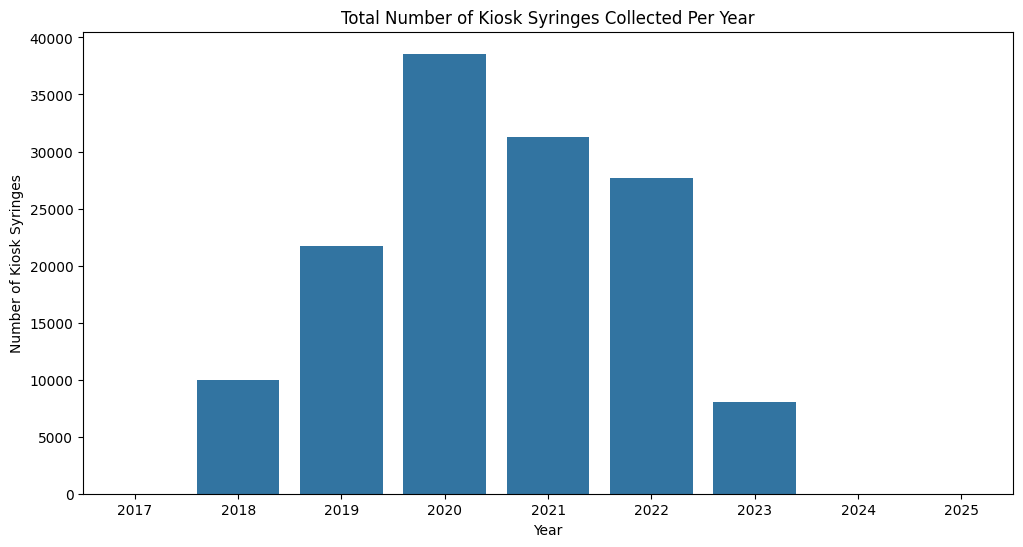

In [ ]:
syringe_data_nyc_parks_df['collected_date'] = pd.to_datetime(syringe_data_nyc_parks_df['collected_date'])

syringe_data_nyc_parks_df['year'] = syringe_data_nyc_parks_df['collected_date'].dt.year

kiosk_syringes_per_year = syringe_data_nyc_parks_df.groupby('year').sum('kiosk_syringes')['kiosk_syringes']
plt.figure(figsize=(12, 6))
sns.barplot(x=kiosk_syringes_per_year.index, y=kiosk_syringes_per_year)
plt.title('Total Number of Kiosk Syringes Collected Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Kiosk Syringes')
plt.xticks(range(0, 9))
plt.show()

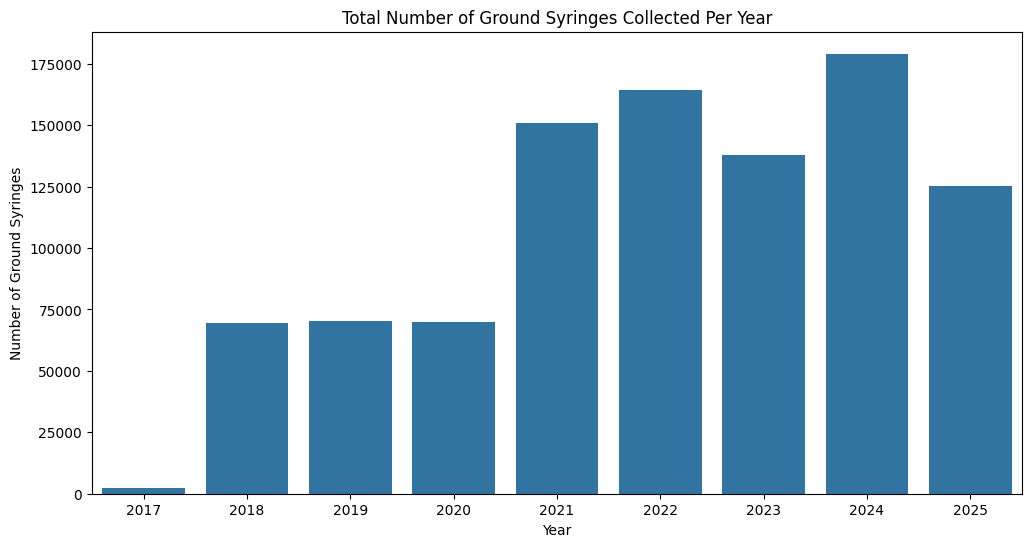

In [ ]:
syringe_data_nyc_parks_df["ground_syringes"] = pd.to_numeric(syringe_data_nyc_parks_df.ground_syringes, errors='coerce')
ground_syringes_per_year = syringe_data_nyc_parks_df.groupby('year').sum('ground_syringes')['ground_syringes']
plt.figure(figsize=(12, 6))
sns.barplot(x=ground_syringes_per_year.index, y=ground_syringes_per_year)
plt.title('Total Number of Ground Syringes Collected Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Ground Syringes')
plt.xticks(range(0, 9))
plt.show()

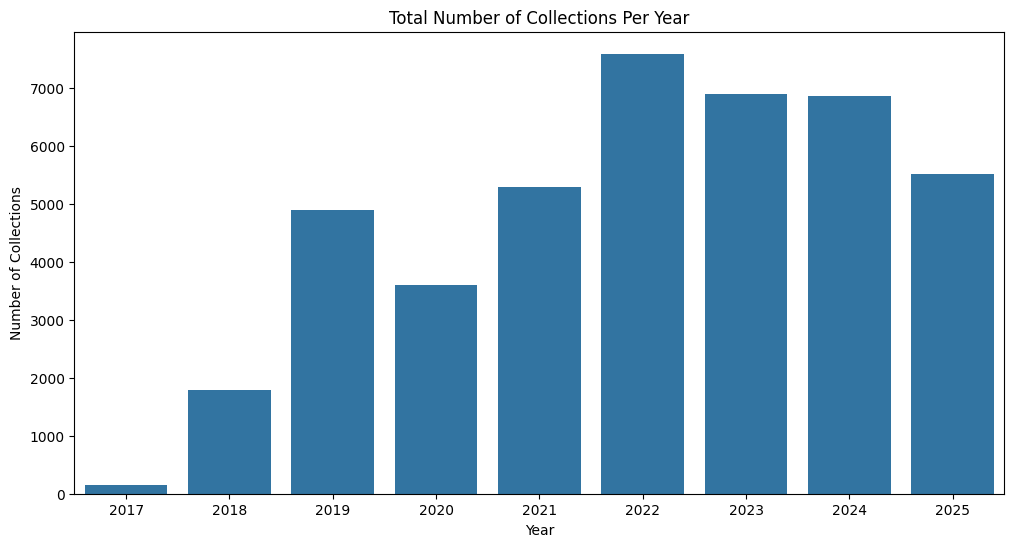

In [ ]:
num_collections_per_year = syringe_data_nyc_parks_df.groupby('year').size()
plt.figure(figsize=(12, 6))
sns.barplot(x=num_collections_per_year.index, y=num_collections_per_year)
plt.title('Total Number of Collections Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Collections')
plt.xticks(range(0, 9))
plt.show()

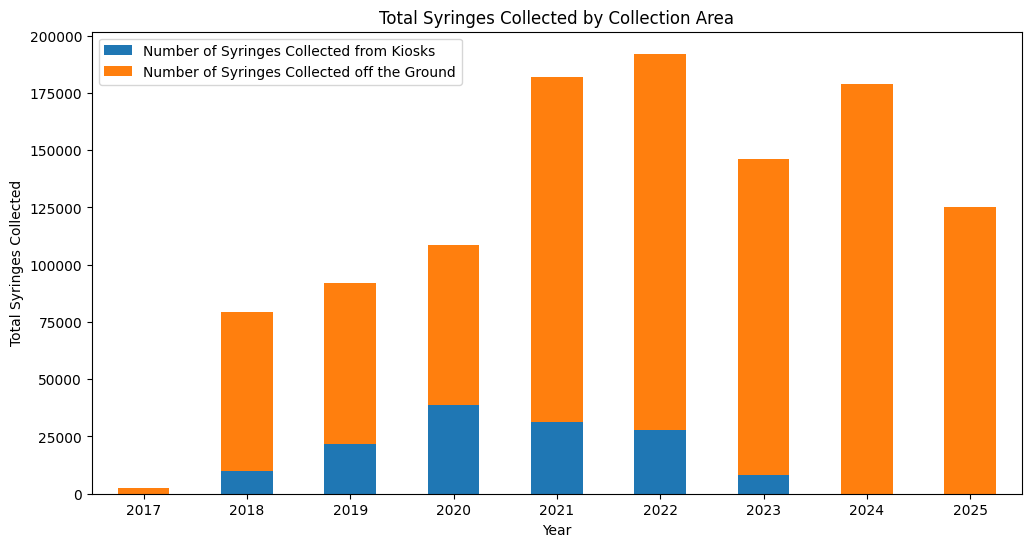

In [ ]:
total_syringes_per_year = pd.concat([kiosk_syringes_per_year, ground_syringes_per_year], axis=1)
total_syringes_per_year.plot(kind='bar', stacked=True, figsize=(12, 6), rot=0)
plt.xlabel('Year')
plt.ylabel('Total Syringes Collected')
plt.title('Total Syringes Collected by Collection Area')
legend = plt.legend()
legend.get_texts()[0].set_text('Number of Syringes Collected from Kiosks')
legend.get_texts()[1].set_text('Number of Syringes Collected off the Ground')
plt.show()

## Data Preparation

In [ ]:
path = "/content/drive/MyDrive"
syringe_service_requests_df = pd.read_csv(f"{path}/311_Service_Requests_from_2010_to_Present_20251026.csv")

In [ ]:
syringe_service_requests_df.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location
0,66601292,10/24/2025 09:47:16 PM,NaN,DSNY,Department of Sanitation,Dirty Condition,Syringes,Sidewalk,10002.0,200 ORCHARD STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.722396,-73.988015,"(40.72239574595509, -73.98801534035735)"
1,66598641,10/24/2025 11:37:22 AM,NaN,DSNY,Department of Sanitation,Dirty Condition,Syringes,Sidewalk,10453.0,CLIFFORD PLACE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.846211,-73.912265,"(40.84621085333982, -73.9122645521403)"
2,66585672,10/23/2025 04:43:42 PM,10/24/2025 03:45:50 PM,DSNY,Department of Sanitation,Dirty Condition,Syringes,Street,11231.0,654 HENRY STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.678793,-74.001987,"(40.67879299903797, -74.00198652314631)"
3,66584002,10/23/2025 07:34:30 AM,10/24/2025 01:44:44 PM,DSNY,Department of Sanitation,Dirty Condition,Syringes,Sidewalk,11372.0,93-30 ROOSEVELT AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.748813,-73.872675,"(40.748812864174326, -73.87267470917251)"
4,66569785,10/22/2025 06:03:03 PM,NaN,DSNY,Department of Sanitation,Dirty Condition,Syringes,Sidewalk,11102.0,24-63 27 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.772778,-73.919192,"(40.772778085634826, -73.9191921649946)"


According to the data dictionary (available for download [here](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9/about_data)), each row of the dataset corresponds to a 311 service request. When I downloaded the data, I only selected for service requests about syringes so the dataframe does not contain all the data that is in the original dataset. Also, the dataset is changed and published daily so the data here differs from the dataset.

The following information is also from the data dictionary and provides more information about the data:

> NYC311 responds to thousands of inquiries, comments and requests from customers every single day. This dataset represents only service requests that can be directed to specific agencies. This dataset is updated daily and expected values for many fields will change over time.  The lists of expected values associated with each column are not exhaustive. Each row of data contains information about the service request, including complaint type, responding agency, and geographic location. However the data does not reveal any personally identifying information about the customer who made the request. This dataset describes site-specific non-emergency complaints (also known as “service requests”) made by customers across New York City about a variety of topics, including noise, sanitation, and street quality. This dataset does not include inquiries, some of which appear in the 311 Call Center Inquiry dataset or requests to agencies which have their own customer service response systems, like the New York City Housing Authority (NYCHA) or New York City Department of Corrections (DOC). Keep in mind, this data represents complaints about the city, as opposed to objective snapshots of city services. For example, if a significant number of noise complaints come from one neighborhood, it doesn’t mean it’s the noisiest neighborhood in the city -- rather, that more people are complaining about noise there. This data has been geocoded before being published to NYC Open Data. Certain fields have been added to provide additional geospatial references, using GeoSupport and the street address provided in the original service request.  The complete list of geocoded fields in this dataset could not be verified.

In [ ]:
syringe_service_requests_df.shape

(3947, 41)

There are 41 columns/features and 3947 rows/samples (before cleaning).

In [ ]:
syringe_service_requests_df.describe()

,Unique Key,Incident Zip,Due Date,BBL,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude
count,3.947000e+03,3884.000000,0.0,2.764000e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3795.000000,3795.000000
mean,5.724843e+07,10463.462667,NaN,2.018837e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.752424,-73.957282
std,6.081964e+06,521.320797,NaN,1.183630e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.070761,0.058121
min,4.414131e+07,10000.000000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.501507,-74.241269
25%,5.269386e+07,10019.000000,NaN,1.010560e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.713963,-73.990232
50%,5.792580e+07,10301.000000,NaN,2.022755e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.754507,-73.953503
75%,6.227871e+07,11205.000000,NaN,3.023688e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.809402,-73.925940
max,6.660129e+07,11694.000000,NaN,5.080360e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.905391,-73.717642


1. `Unique Key`: There is a unique identifier for each service request. There is a total of 3947.
2. `Incident Zip`: This indicates the zip code of the incident. There is almost one recorded for every incident. The zip codes range from 10000 to 11694.
3. `Due Date` / `Vehicle Type`/ `Taxi Company Borough` / `Taxi Pick Up Location` / `Bridge Highway Name` / `Bridge Highway Segment` / `Road Ramp` / `Bridge Highway Direction`: These fields do not have any recorded data. Possibly since they are not related to syringe litter.
4. `BBL`: This indicates the "parcel number that identifies the location of the building or property associated with the service request. The block is a subset of a borough. The lot is a subset of a block unique within a borough and block". Not all incidents have a BBL. Only ~73% do.
5. `Latitude`: This indicates the latitude in decimal degrees. ~97% of incidents have a latitude.
6. `Longitude`: This indicates the longitude in decimal degrees. ~97% of incidents have a longitude.

In [ ]:
syringe_service_requests_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3947 entries, 0 to 3946
Data columns (total 41 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unique Key                      3947 non-null   int64  
 1   Created Date                    3947 non-null   object 
 2   Closed Date                     3939 non-null   object 
 3   Agency                          3947 non-null   object 
 4   Agency Name                     3947 non-null   object 
 5   Complaint Type                  3947 non-null   object 
 6   Descriptor                      3947 non-null   object 
 7   Location Type                   3947 non-null   object 
 8   Incident Zip                    3884 non-null   float64
 9   Incident Address                3667 non-null   object 
 10  Street Name                     3667 non-null   object 
 11  Cross Street 1                  3489 non-null   object 
 12  Cross Street 2                  34

### Dealing with Missing and Invalid Values

In [ ]:
missing_values = syringe_service_requests_df.isnull().sum()

missing_values_percentage = (missing_values / len(syringe_service_requests_df)) * 100

missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage (%)': missing_values_percentage})
missing_data.sort_values(by='Percentage (%)', ascending=False)

,Missing Values,Percentage (%)
Due Date,3947,100.000000
Vehicle Type,3947,100.000000
Taxi Company Borough,3947,100.000000
Bridge Highway Name,3947,100.000000
Bridge Highway Segment,3947,100.000000
Road Ramp,3947,100.000000
Bridge Highway Direction,3947,100.000000
Taxi Pick Up Location,3947,100.000000
Facility Type,3250,82.341018
Landmark,1504,38.104890


`Due Date`, `Bridge Highway Direction`, `Road Ramp`, `Bridge Highway Segment`, `Bridge Highway Name`, `Taxi Company Borough`, `Vehicle Type`, `Taxi Pick Up Location` do not contain any data. This is possibly since they are unrelated to the related syringe litter incidents.

`BBL` and `Facility Type` have a significant amount of data missing. This may be since not all incidents have a property or building that is identified by a parcel number or facility or they may be missing due to error.

`Landmark` and `City` have a similar number of missing values. `Landmark` does not have many since not all incidents occur by a landmark.

`X Coordinate (State Plane)`, `Y Coordinate (State Plane)`, `Latitude`, `Longitude`, and `Location` all have a similar number of missing values, possibly since when one is missing so are the others. `Y Coordinate (State Plane)` may have one less than the others in the grup due to error.

`Closed Date` does not have a value when Status is marked as "In Progress".

`Cross Street 1` and `Cross Street 2` do not have values when there are no cross streets based on the geovalidated locations.

In [ ]:
syringe_service_requests_df['Descriptor'].value_counts()

,count
Descriptor,
Syringes,3101
15N Needle/Syringe on Street/Sidewalk,846


In [ ]:
syringe_service_requests_df['Status'].value_counts()

,count
Status,
Closed,3927
Unspecified,9
In Progress,8
Pending,3


In [ ]:
syringe_service_requests_df[syringe_service_requests_df['Status']=="Unspecified"]["Resolution Action Updated Date"]

,Resolution Action Updated Date
1578,11/08/2023 08:49:59 PM
1593,11/05/2023 02:04:24 PM
1886,07/13/2023 07:39:20 AM
1893,07/23/2023 07:30:33 AM
1902,07/15/2023 07:47:06 AM
1905,07/15/2023 07:47:06 AM
2314,10/27/2022 07:31:38 AM
2316,10/27/2022 07:31:38 AM
2593,07/11/2022 08:57:16 AM


In [ ]:
syringe_service_requests_df[syringe_service_requests_df['Status']=="In Progress"]["Resolution Description"]

,Resolution Description
0,NaN
1,NaN
4,The Department of Sanitation investigated this...
7,The Department of Sanitation investigated this...
1660,NaN
1661,NaN
1791,NaN
2258,The Department of Sanitation (DSNY) found that...


In [ ]:
syringe_service_requests_df[syringe_service_requests_df['Status']=="Pending"]["Location"]

,Location
3687,NaN
3945,"(40.71715662253744, -74.00065293584422)"
3946,"(40.68878005820832, -73.96081167348456)"


In [ ]:
all_vals_missing_cols = ['Due Date', 'Vehicle Type', 'Taxi Company Borough', 'Bridge Highway Name', 'Bridge Highway Segment', 'Road Ramp', 'Bridge Highway Direction', 'Taxi Pick Up Location']
syringe_service_requests_df.drop(all_vals_missing_cols, axis=1, inplace=True)
syringe_service_requests_df.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,BBL,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Open Data Channel Type,Park Facility Name,Park Borough,Latitude,Longitude,Location
0,66601292,10/24/2025 09:47:16 PM,NaN,DSNY,Department of Sanitation,Dirty Condition,Syringes,Sidewalk,10002.0,200 ORCHARD STREET,...,1.004128e+09,MANHATTAN,"987,572","202,465",ONLINE,Unspecified,MANHATTAN,40.722396,-73.988015,"(40.72239574595509, -73.98801534035735)"
1,66598641,10/24/2025 11:37:22 AM,NaN,DSNY,Department of Sanitation,Dirty Condition,Syringes,Sidewalk,10453.0,CLIFFORD PLACE,...,NaN,BRONX,"1,008,524","247,587",PHONE,Unspecified,BRONX,40.846211,-73.912265,"(40.84621085333982, -73.9122645521403)"
2,66585672,10/23/2025 04:43:42 PM,10/24/2025 03:45:50 PM,DSNY,Department of Sanitation,Dirty Condition,Syringes,Street,11231.0,654 HENRY STREET,...,3.003720e+09,BROOKLYN,"983,699","186,579",PHONE,Unspecified,BROOKLYN,40.678793,-74.001987,"(40.67879299903797, -74.00198652314631)"
3,66584002,10/23/2025 07:34:30 AM,10/24/2025 01:44:44 PM,DSNY,Department of Sanitation,Dirty Condition,Syringes,Sidewalk,11372.0,93-30 ROOSEVELT AVENUE,...,4.015620e+09,QUEENS,"1,019,529","212,115",ONLINE,Unspecified,QUEENS,40.748813,-73.872675,"(40.748812864174326, -73.87267470917251)"
4,66569785,10/22/2025 06:03:03 PM,NaN,DSNY,Department of Sanitation,Dirty Condition,Syringes,Sidewalk,11102.0,24-63 27 STREET,...,4.008510e+09,QUEENS,"1,006,632","220,831",ONLINE,Unspecified,QUEENS,40.772778,-73.919192,"(40.772778085634826, -73.9191921649946)"


In [ ]:
syringe_service_requests_df['Facility Type'].value_counts()

,count
Facility Type,
DSNY Garage,697


In [ ]:
syringe_service_requests_df[syringe_service_requests_df['Facility Type'] == 'DSNY Garage']['Location Type'].value_counts()

,count
Location Type,
Street,697


In [ ]:
syringe_service_requests_df.drop(syringe_service_requests_df.loc[syringe_service_requests_df['Status']=="In Progress"].index, inplace=True)
syringe_service_requests_df.drop(syringe_service_requests_df.loc[syringe_service_requests_df['Status']=="Pending"].index, inplace=True)
syringe_service_requests_df.drop(['Unique Key'], axis=1, inplace=True)
syringe_service_requests_df.head()

,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,...,BBL,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Open Data Channel Type,Park Facility Name,Park Borough,Latitude,Longitude,Location
2,10/23/2025 04:43:42 PM,10/24/2025 03:45:50 PM,DSNY,Department of Sanitation,Dirty Condition,Syringes,Street,11231.0,654 HENRY STREET,HENRY STREET,...,3.003720e+09,BROOKLYN,"983,699","186,579",PHONE,Unspecified,BROOKLYN,40.678793,-74.001987,"(40.67879299903797, -74.00198652314631)"
3,10/23/2025 07:34:30 AM,10/24/2025 01:44:44 PM,DSNY,Department of Sanitation,Dirty Condition,Syringes,Sidewalk,11372.0,93-30 ROOSEVELT AVENUE,ROOSEVELT AVENUE,...,4.015620e+09,QUEENS,"1,019,529","212,115",ONLINE,Unspecified,QUEENS,40.748813,-73.872675,"(40.748812864174326, -73.87267470917251)"
5,10/22/2025 05:45:50 PM,10/24/2025 03:46:15 PM,DSNY,Department of Sanitation,Dirty Condition,Syringes,Sidewalk,11228.0,7699 10 AVENUE,10 AVENUE,...,NaN,BROOKLYN,"980,045","166,329",ONLINE,Unspecified,BROOKLYN,40.623210,-74.015148,"(40.62321017314334, -74.01514768332007)"
6,10/22/2025 01:35:46 PM,10/24/2025 03:05:46 PM,DSNY,Department of Sanitation,Dirty Condition,Syringes,Sidewalk,10014.0,15 DOWNING STREET,DOWNING STREET,...,1.005270e+09,MANHATTAN,"983,423","205,076",PHONE,Unspecified,MANHATTAN,40.729563,-74.002984,"(40.7295628913009, -74.00298385896821)"
8,10/20/2025 08:19:07 AM,10/22/2025 02:35:09 PM,DSNY,Department of Sanitation,Dirty Condition,Syringes,Sidewalk,10001.0,132 WEST 26 STREET,WEST 26 STREET,...,1.008010e+09,MANHATTAN,"986,328","210,791",ONLINE,Unspecified,MANHATTAN,40.745249,-73.992501,"(40.74524894672425, -73.99250070274657)"


In [ ]:
syringe_service_requests_df['Agency'].value_counts()

,count
Agency,
DSNY,3936


In [ ]:
syringe_service_requests_df['Agency Name'].value_counts()

,count
Agency Name,
Department of Sanitation,3936


In [ ]:
syringe_service_requests_df['Descriptor'].value_counts()

,count
Descriptor,
Syringes,3093
15N Needle/Syringe on Street/Sidewalk,843


In [ ]:
syringe_service_requests_df['Park Facility Name'].value_counts()

,count
Park Facility Name,
Unspecified,3936


In [ ]:
syringe_service_requests_df['Park Borough'].value_counts()

,count
Park Borough,
MANHATTAN,1924
BROOKLYN,827
BRONX,692
QUEENS,306
STATEN ISLAND,171
Unspecified,5


In [ ]:
syringe_service_requests_df['Borough'].value_counts()

,count
Borough,
MANHATTAN,1924
BROOKLYN,827
BRONX,692
QUEENS,306
STATEN ISLAND,171
Unspecified,5


In [ ]:
syringe_service_requests_df['Complaint Type'].value_counts()

,count
Complaint Type,
Dirty Condition,3093
Sanitation Condition,843


In [ ]:
identical_data_cols = ['Agency', 'Agency Name', 'Park Facility Name']
repeat_cols = ['Complaint Type', 'Descriptor', 'Park Borough', 'Location', 'X Coordinate (State Plane)', 'Y Coordinate (State Plane)', 'Intersection Street 1', 'Intersection Street 2', 'Street Name']
syringe_service_requests_df.drop(identical_data_cols, axis=1, inplace=True)
syringe_service_requests_df.drop(repeat_cols, axis=1, inplace=True)
syringe_service_requests_df.head()

,Created Date,Closed Date,Location Type,Incident Zip,Incident Address,Cross Street 1,Cross Street 2,Address Type,City,Landmark,Facility Type,Status,Resolution Description,Resolution Action Updated Date,Community Board,BBL,Borough,Open Data Channel Type,Latitude,Longitude
2,10/23/2025 04:43:42 PM,10/24/2025 03:45:50 PM,Street,11231.0,654 HENRY STREET,COLES STREET,BROOKLYN QUEENS EXPWY EB ET 26,ADDRESS,BROOKLYN,HENRY STREET,NaN,Closed,The Department of Sanitation investigated this...,10/24/2025 04:23:26 AM,06 BROOKLYN,3.003720e+09,BROOKLYN,PHONE,40.678793,-74.001987
3,10/23/2025 07:34:30 AM,10/24/2025 01:44:44 PM,Sidewalk,11372.0,93-30 ROOSEVELT AVENUE,94 STREET,94 STREET,ADDRESS,JACKSON HEIGHTS,ROOSEVELT AVENUE,NaN,Closed,The Department of Sanitation investigated this...,10/23/2025 01:08:42 PM,04 QUEENS,4.015620e+09,QUEENS,ONLINE,40.748813,-73.872675
5,10/22/2025 05:45:50 PM,10/24/2025 03:46:15 PM,Sidewalk,11228.0,7699 10 AVENUE,76 STREET,77 STREET,ADDRESS,BROOKLYN,10 AVENUE,NaN,Closed,The Department of Sanitation investigated this...,10/24/2025 01:42:37 PM,10 BROOKLYN,NaN,BROOKLYN,ONLINE,40.623210,-74.015148
6,10/22/2025 01:35:46 PM,10/24/2025 03:05:46 PM,Sidewalk,10014.0,15 DOWNING STREET,AVENUE OF THE AMERICAS,BEDFORD STREET,ADDRESS,NEW YORK,DOWNING STREET,NaN,Closed,The Department of Sanitation investigated this...,10/22/2025 10:37:46 PM,02 MANHATTAN,1.005270e+09,MANHATTAN,PHONE,40.729563,-74.002984
8,10/20/2025 08:19:07 AM,10/22/2025 02:35:09 PM,Sidewalk,10001.0,132 WEST 26 STREET,AVENUE OF THE AMERICAS,7 AVENUE,ADDRESS,NEW YORK,WEST 26 STREET,NaN,Closed,The Department of Sanitation investigated this...,10/20/2025 11:55:17 PM,04 MANHATTAN,1.008010e+09,MANHATTAN,ONLINE,40.745249,-73.992501


In [ ]:
# need longitude and latitude to map clusters and identify hotspots
syringe_service_requests_df.dropna(subset=['Latitude', 'Longitude', 'Resolution Description'], inplace=True)
missing_values = syringe_service_requests_df.isnull().sum()

missing_values_percentage = (missing_values / len(syringe_service_requests_df)) * 100

missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage (%)': missing_values_percentage})
missing_data.sort_values(by='Percentage (%)', ascending=False)

,Missing Values,Percentage (%)
Facility Type,3156,83.514157
Landmark,1342,35.512040
BBL,1024,27.097116
City,575,15.215666
Cross Street 2,423,11.193437
Cross Street 1,405,10.717121
Incident Address,229,6.059804
Created Date,0,0.000000
Incident Zip,0,0.000000
Location Type,0,0.000000


In [ ]:
many_missing_vals_cols = ['Facility Type', 'Landmark', 'BBL', 'Cross Street 2', 'Cross Street 1', 'Incident Address', 'City']
syringe_service_requests_df.drop(many_missing_vals_cols, axis=1, inplace=True)
syringe_service_requests_df.dropna(subset=['Resolution Description'], inplace=True)
syringe_service_requests_df.head()

,Created Date,Closed Date,Location Type,Incident Zip,Address Type,Status,Resolution Description,Resolution Action Updated Date,Community Board,Borough,Open Data Channel Type,Latitude,Longitude
2,10/23/2025 04:43:42 PM,10/24/2025 03:45:50 PM,Street,11231.0,ADDRESS,Closed,The Department of Sanitation investigated this...,10/24/2025 04:23:26 AM,06 BROOKLYN,BROOKLYN,PHONE,40.678793,-74.001987
3,10/23/2025 07:34:30 AM,10/24/2025 01:44:44 PM,Sidewalk,11372.0,ADDRESS,Closed,The Department of Sanitation investigated this...,10/23/2025 01:08:42 PM,04 QUEENS,QUEENS,ONLINE,40.748813,-73.872675
5,10/22/2025 05:45:50 PM,10/24/2025 03:46:15 PM,Sidewalk,11228.0,ADDRESS,Closed,The Department of Sanitation investigated this...,10/24/2025 01:42:37 PM,10 BROOKLYN,BROOKLYN,ONLINE,40.623210,-74.015148
6,10/22/2025 01:35:46 PM,10/24/2025 03:05:46 PM,Sidewalk,10014.0,ADDRESS,Closed,The Department of Sanitation investigated this...,10/22/2025 10:37:46 PM,02 MANHATTAN,MANHATTAN,PHONE,40.729563,-74.002984
8,10/20/2025 08:19:07 AM,10/22/2025 02:35:09 PM,Sidewalk,10001.0,ADDRESS,Closed,The Department of Sanitation investigated this...,10/20/2025 11:55:17 PM,04 MANHATTAN,MANHATTAN,ONLINE,40.745249,-73.992501


In [ ]:
missing_values = syringe_service_requests_df.isnull().sum()

missing_values_percentage = (missing_values / len(syringe_service_requests_df)) * 100

missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage (%)': missing_values_percentage})
missing_data.sort_values(by='Percentage (%)', ascending=False)

,Missing Values,Percentage (%)
Created Date,0,0.0
Closed Date,0,0.0
Location Type,0,0.0
Incident Zip,0,0.0
Address Type,0,0.0
Status,0,0.0
Resolution Description,0,0.0
Resolution Action Updated Date,0,0.0
Community Board,0,0.0
Borough,0,0.0


In [ ]:
syringe_service_requests_df['Community Board'].value_counts()

,count
Community Board,
04 MANHATTAN,463
12 MANHATTAN,263
01 BRONX,259
01 BROOKLYN,259
05 MANHATTAN,216
...,...
Unspecified BRONX,3
64 MANHATTAN,1
28 BRONX,1


In [ ]:
syringe_service_requests_df[syringe_service_requests_df['Community Board'].str.contains('Unspecified')]['Community Board'].value_counts()

,count
Community Board,
Unspecified MANHATTAN,7
Unspecified BRONX,3
Unspecified STATEN ISLAND,1
Unspecified QUEENS,1


In [ ]:
syringe_service_requests_df['Address Type'].value_counts()

,count
Address Type,
ADDRESS,2920
INTERSECTION,804
BLOCKFACE,47
UNRECOGNIZED,7
PLACE,1


In [ ]:
syringe_service_requests_df['Location Type'].value_counts()

,count
Location Type,
Sidewalk,2432
Street,1214
Gutter,92
Traffic Island or Median,41


In [ ]:
syringe_service_requests_df['Borough'].value_counts()

,count
Borough,
MANHATTAN,1860
BROOKLYN,798
BRONX,663
QUEENS,296
STATEN ISLAND,162


In [ ]:
syringe_service_requests_df['Status'].value_counts()

,count
Status,
Closed,3770
Unspecified,9


In [ ]:
# drop unspecific values
syringe_service_requests_df = syringe_service_requests_df[syringe_service_requests_df['Address Type'] != 'UNRECOGNIZED']
syringe_service_requests_df = syringe_service_requests_df[syringe_service_requests_df['Address Type'] != 'PLACE']
syringe_service_requests_df = syringe_service_requests_df[~syringe_service_requests_df['Community Board'].str.contains('Unspecified')]
syringe_service_requests_df.drop(['Open Data Channel Type', 'Status'], axis=1, inplace=True)
syringe_service_requests_df = syringe_service_requests_df[syringe_service_requests_df['Resolution Description'] != 'The Department of Sanitation found an open service request already exists for the same location.']
syringe_service_requests_df = syringe_service_requests_df[syringe_service_requests_df['Resolution Description'] != 'The Department of Sanitation investigated and found this complaint to be out of jurisdiction. The Department of Sanitation reviewed this and found it not to be meeting the criteria for a complaint or service request.']
syringe_service_requests_df.head()

,Created Date,Closed Date,Location Type,Incident Zip,Address Type,Resolution Description,Resolution Action Updated Date,Community Board,Borough,Latitude,Longitude
2,10/23/2025 04:43:42 PM,10/24/2025 03:45:50 PM,Street,11231.0,ADDRESS,The Department of Sanitation investigated this...,10/24/2025 04:23:26 AM,06 BROOKLYN,BROOKLYN,40.678793,-74.001987
3,10/23/2025 07:34:30 AM,10/24/2025 01:44:44 PM,Sidewalk,11372.0,ADDRESS,The Department of Sanitation investigated this...,10/23/2025 01:08:42 PM,04 QUEENS,QUEENS,40.748813,-73.872675
5,10/22/2025 05:45:50 PM,10/24/2025 03:46:15 PM,Sidewalk,11228.0,ADDRESS,The Department of Sanitation investigated this...,10/24/2025 01:42:37 PM,10 BROOKLYN,BROOKLYN,40.623210,-74.015148
6,10/22/2025 01:35:46 PM,10/24/2025 03:05:46 PM,Sidewalk,10014.0,ADDRESS,The Department of Sanitation investigated this...,10/22/2025 10:37:46 PM,02 MANHATTAN,MANHATTAN,40.729563,-74.002984
8,10/20/2025 08:19:07 AM,10/22/2025 02:35:09 PM,Sidewalk,10001.0,ADDRESS,The Department of Sanitation investigated this...,10/20/2025 11:55:17 PM,04 MANHATTAN,MANHATTAN,40.745249,-73.992501


In [ ]:
# source: https://stackoverflow.com/questions/37840812/pandas-subtracting-two-date-columns-and-the-result-being-an-integer
fmt = "%m/%d/%Y %I:%M:%S %p"
tz = "America/New_York"
start_date = syringe_service_requests_df['Created Date'].min()
end_date = syringe_service_requests_df['Closed Date'].max()

syringe_service_requests_df['Created Date'] = pd.to_datetime(syringe_service_requests_df['Created Date'], format=fmt)
syringe_service_requests_df['Closed Date'] = pd.to_datetime(syringe_service_requests_df['Closed Date'], format=fmt)
syringe_service_requests_df['Resolution Action Updated Date'] = pd.to_datetime(syringe_service_requests_df['Resolution Action Updated Date'], format=fmt)

syringe_service_requests_df['Time Diff Between Incident and Resolution'] = syringe_service_requests_df['Resolution Action Updated Date'] - syringe_service_requests_df['Created Date']
syringe_service_requests_df['Time Diff Between Resolution and Closed'] = syringe_service_requests_df['Closed Date'] - syringe_service_requests_df['Resolution Action Updated Date']
syringe_service_requests_df['Time Diff Between Incident and Closed'] = syringe_service_requests_df['Closed Date'] - syringe_service_requests_df['Created Date']

syringe_service_requests_df['Days Between Incident and Resolution'] = syringe_service_requests_df['Time Diff Between Incident and Resolution'].dt.days
syringe_service_requests_df['Hours Between Incident and Resolution'] = syringe_service_requests_df['Time Diff Between Incident and Resolution'].dt.total_seconds() / 3600
syringe_service_requests_df['Minutes Between Incident and Resolution'] = syringe_service_requests_df['Time Diff Between Incident and Resolution'].dt.total_seconds() / 60
syringe_service_requests_df['Seconds Between Incident and Resolution'] = syringe_service_requests_df['Time Diff Between Incident and Resolution'].dt.total_seconds()

syringe_service_requests_df['Days Between Resolution and Closed'] = syringe_service_requests_df['Time Diff Between Resolution and Closed'].dt.days
syringe_service_requests_df['Hours Between Resolution and Closed'] = syringe_service_requests_df['Time Diff Between Resolution and Closed'].dt.total_seconds() / 3600
syringe_service_requests_df['Minutes Between Resolution and Closed'] = syringe_service_requests_df['Time Diff Between Resolution and Closed'].dt.total_seconds() / 60
syringe_service_requests_df['Seconds Between Resolution and Closed'] = syringe_service_requests_df['Time Diff Between Resolution and Closed'].dt.total_seconds()

syringe_service_requests_df['Days Between Incident and Closed'] = syringe_service_requests_df['Time Diff Between Incident and Closed'].dt.days
syringe_service_requests_df['Hours Between Incident and Closed'] = syringe_service_requests_df['Time Diff Between Incident and Closed'].dt.total_seconds() / 3600
syringe_service_requests_df['Minutes Between Incident and Closed'] = syringe_service_requests_df['Time Diff Between Incident and Closed'].dt.total_seconds() / 60
syringe_service_requests_df['Seconds Between Incident and Closed'] = syringe_service_requests_df['Time Diff Between Incident and Closed'].dt.total_seconds()

syringe_service_requests_df = syringe_service_requests_df[syringe_service_requests_df['Seconds Between Incident and Closed'] != 0]

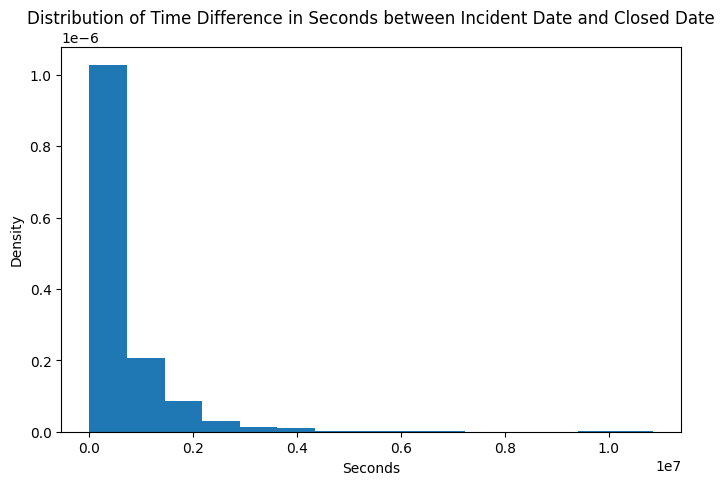

In [ ]:
plt.figure(figsize=(8, 5))
plt.hist(syringe_service_requests_df['Seconds Between Incident and Closed'], bins=15, density=True)
plt.title("Distribution of Time Difference in Seconds between Incident Date and Closed Date")
plt.xlabel("Seconds")
plt.ylabel("Density")
plt.show()

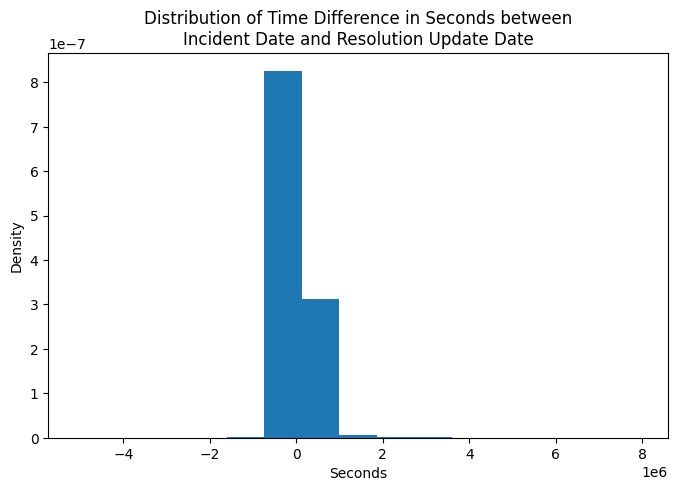

In [ ]:
plt.figure(figsize=(8, 5))
plt.hist(syringe_service_requests_df['Seconds Between Incident and Resolution'], bins=15, density=True)
plt.title("Distribution of Time Difference in Seconds between\nIncident Date and Resolution Update Date")
plt.xlabel("Seconds")
plt.ylabel("Density")
plt.show()

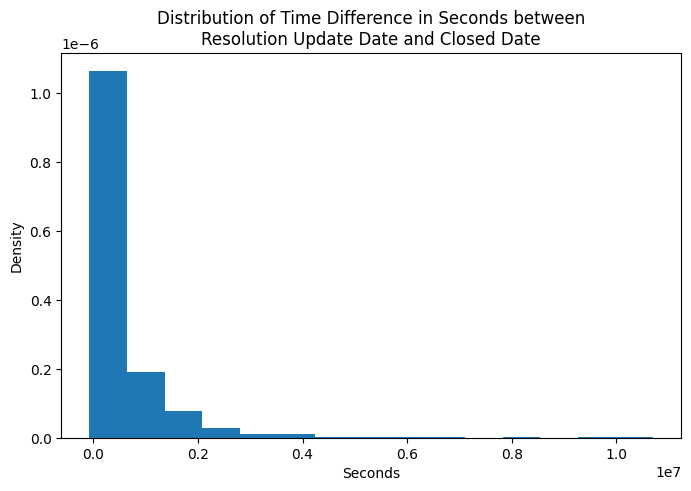

In [ ]:
plt.figure(figsize=(8, 5))
plt.hist(syringe_service_requests_df['Seconds Between Resolution and Closed'], bins=15, density=True)
plt.title("Distribution of Time Difference in Seconds between\nResolution Update Date and Closed Date")
plt.xlabel("Seconds")
plt.ylabel("Density")
plt.show()

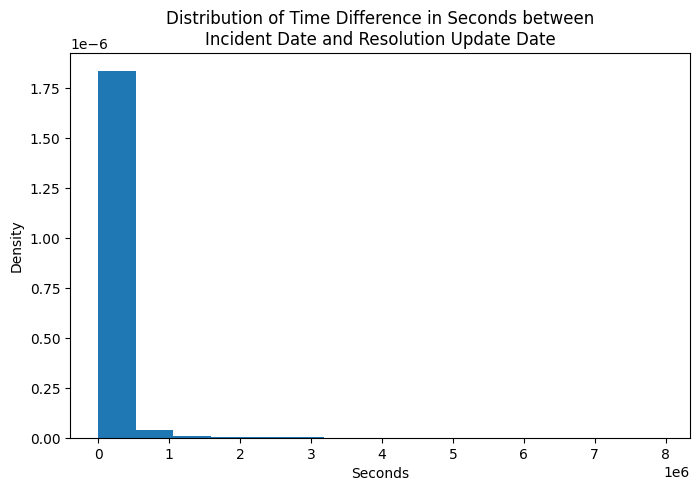

In [ ]:
syringe_service_requests_df = syringe_service_requests_df[syringe_service_requests_df['Seconds Between Incident and Resolution'] >= 0]
plt.figure(figsize=(8, 5))
plt.hist(syringe_service_requests_df['Seconds Between Incident and Resolution'], bins=15, density=True)
plt.title("Distribution of Time Difference in Seconds between\nIncident Date and Resolution Update Date")
plt.xlabel("Seconds")
plt.ylabel("Density")
plt.show()

In [ ]:
syringe_service_requests_df[syringe_service_requests_df['Resolution Action Updated Date'] > syringe_service_requests_df['Closed Date']]

,Created Date,Closed Date,Location Type,Incident Zip,Address Type,Resolution Description,Resolution Action Updated Date,Community Board,Borough,Latitude,...,Minutes Between Incident and Resolution,Seconds Between Incident and Resolution,Days Between Resolution and Closed,Hours Between Resolution and Closed,Minutes Between Resolution and Closed,Seconds Between Resolution and Closed,Days Between Incident and Closed,Hours Between Incident and Closed,Minutes Between Incident and Closed,Seconds Between Incident and Closed
44,2025-10-03 09:39:19,2025-10-06 08:57:17,Sidewalk,10014.0,ADDRESS,The Department of Sanitation has investigated ...,2025-10-06 08:57:18,02 MANHATTAN,MANHATTAN,40.734649,...,4277.983333,256679.0,-1,-0.000278,-0.016667,-1.0,2,71.299444,4277.966667,256678.0
183,2025-08-19 16:53:11,2025-08-20 05:42:53,Street,10014.0,ADDRESS,The Department of Sanitation has investigated ...,2025-08-20 05:42:54,02 MANHATTAN,MANHATTAN,40.733529,...,769.716667,46183.0,-1,-0.000278,-0.016667,-1.0,0,12.828333,769.700000,46182.0
1146,2024-07-06 12:26:40,2024-07-08 08:04:21,Sidewalk,11215.0,ADDRESS,The Department of Sanitation has investigated ...,2024-07-08 08:04:22,07 BROOKLYN,BROOKLYN,40.665450,...,2617.700000,157062.0,-1,-0.000278,-0.016667,-1.0,1,43.628056,2617.683333,157061.0
2028,2023-05-24 11:41:22,2023-05-24 15:42:38,Sidewalk,11102.0,ADDRESS,The Department of Sanitation investigated this...,2023-05-25 12:15:51,01 QUEENS,QUEENS,40.765393,...,1474.483333,88469.0,-1,-20.553611,-1233.216667,-73993.0,0,4.021111,241.266667,14476.0


In [ ]:
syringe_service_requests_df[syringe_service_requests_df['Resolution Action Updated Date'] > syringe_service_requests_df['Closed Date']]['Resolution Description'].value_counts()

,count
Resolution Description,
"The Department of Sanitation has investigated the complaint and addressed the issue. If the problem persists, call 311 to enter a new complaint. If you are outside of New York City, please call (212) NEW-YORK (212-639-9675).",3
The Department of Sanitation investigated this complaint and found no condition at the location.,1


## Exploratory Data Analysis & Feature Engineering

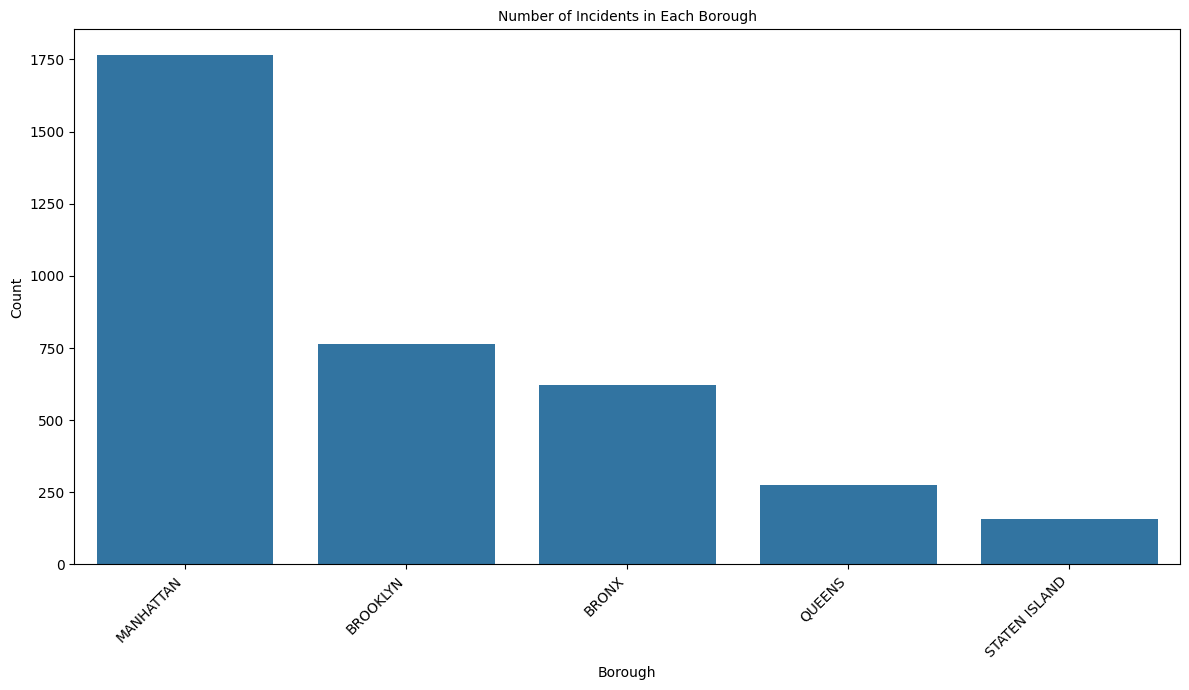

In [ ]:
borough = syringe_service_requests_df['Borough'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(12, 7))
sns.barplot(x=borough.index, y=borough.values)
plt.title('Number of Incidents in Each Borough', fontsize=10)
plt.xlabel('Borough', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

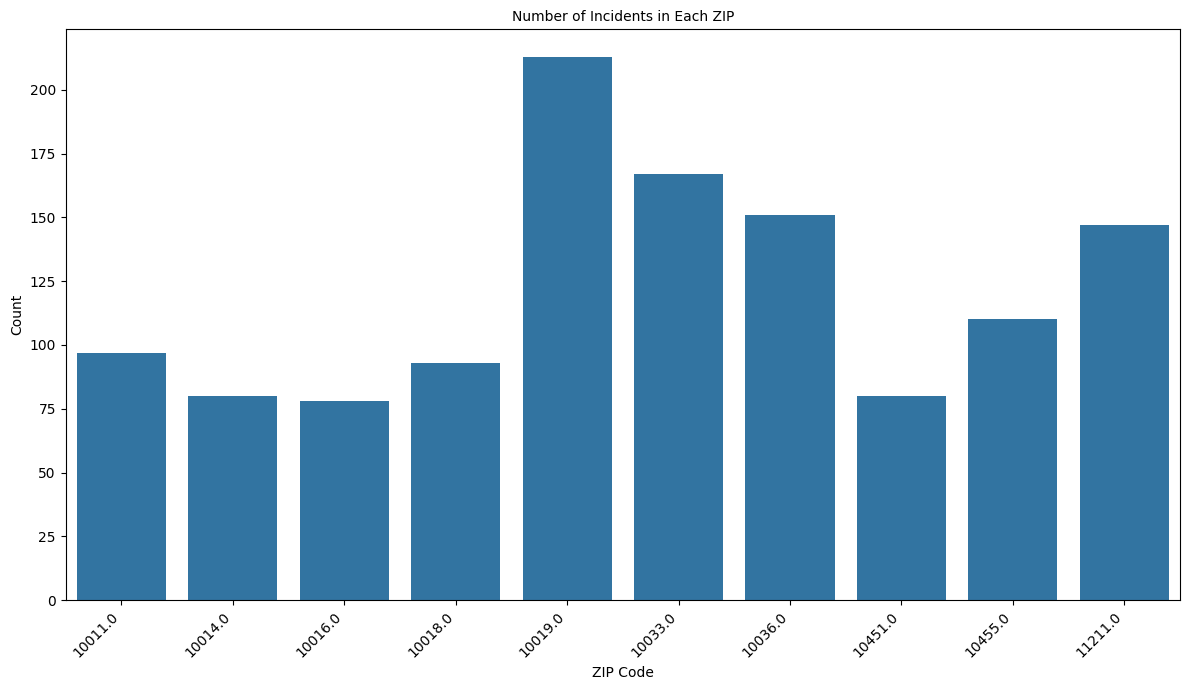

In [ ]:
top_zips = syringe_service_requests_df['Incident Zip'].value_counts().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 7))
sns.barplot(x=top_zips.index, y=top_zips.values)
plt.title('Number of Incidents in Each ZIP', fontsize=10)
plt.xlabel('ZIP Code', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

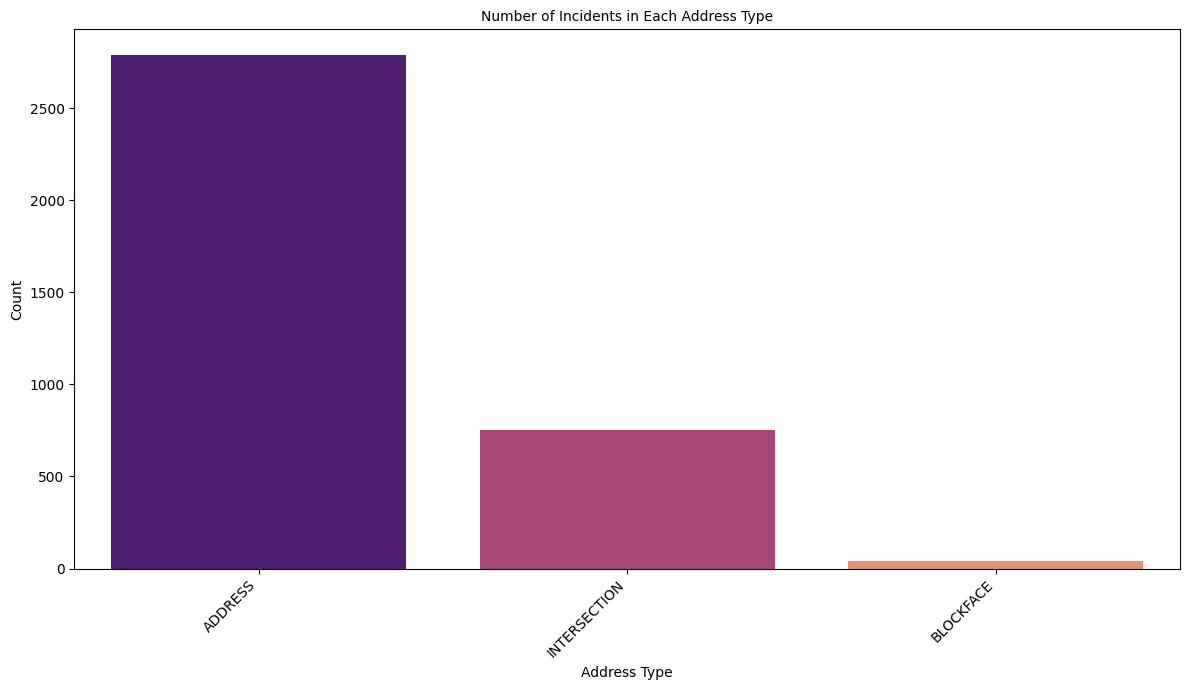

In [ ]:
top_address_types = syringe_service_requests_df['Address Type'].value_counts()
plt.figure(figsize=(12, 7))
sns.barplot(x=top_address_types.index, y=top_address_types.values, palette="magma", hue=top_address_types.index, legend=False)
plt.title('Number of Incidents in Each Address Type', fontsize=10)
plt.xlabel('Address Type', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

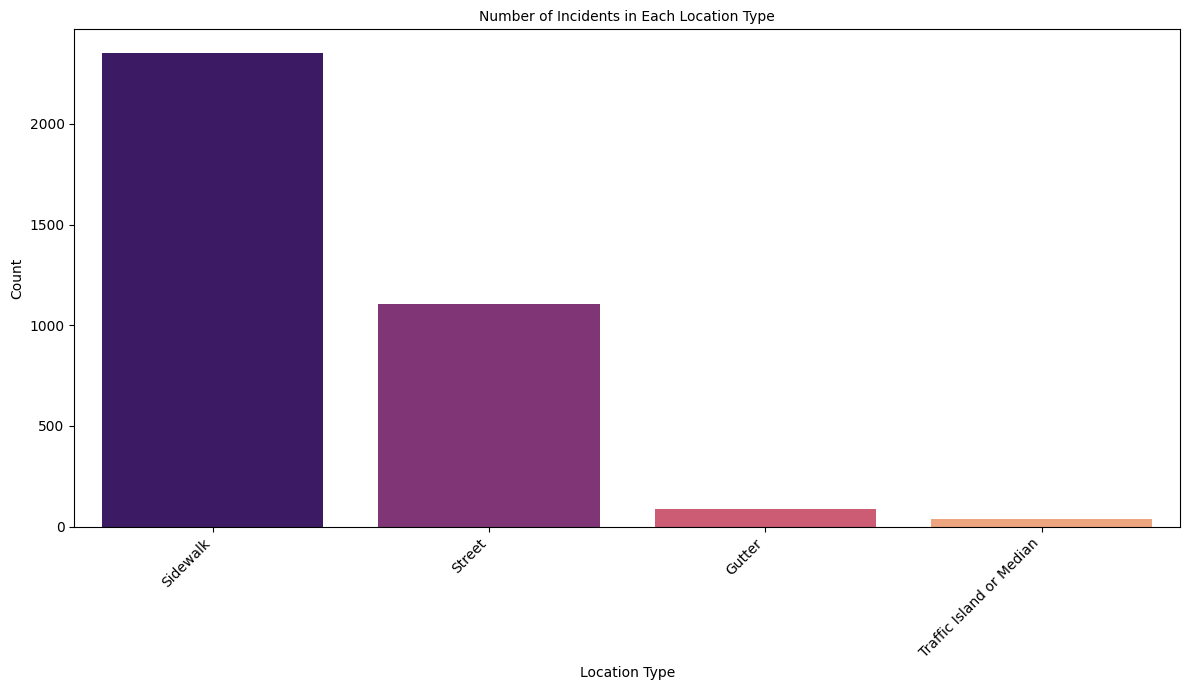

In [ ]:
top_location_types = syringe_service_requests_df['Location Type'].value_counts()
plt.figure(figsize=(12, 7))
sns.barplot(x=top_location_types.index, y=top_location_types.values, palette="magma", hue=top_location_types.index, legend=False)
plt.title('Number of Incidents in Each Location Type', fontsize=10)
plt.xlabel('Location Type', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

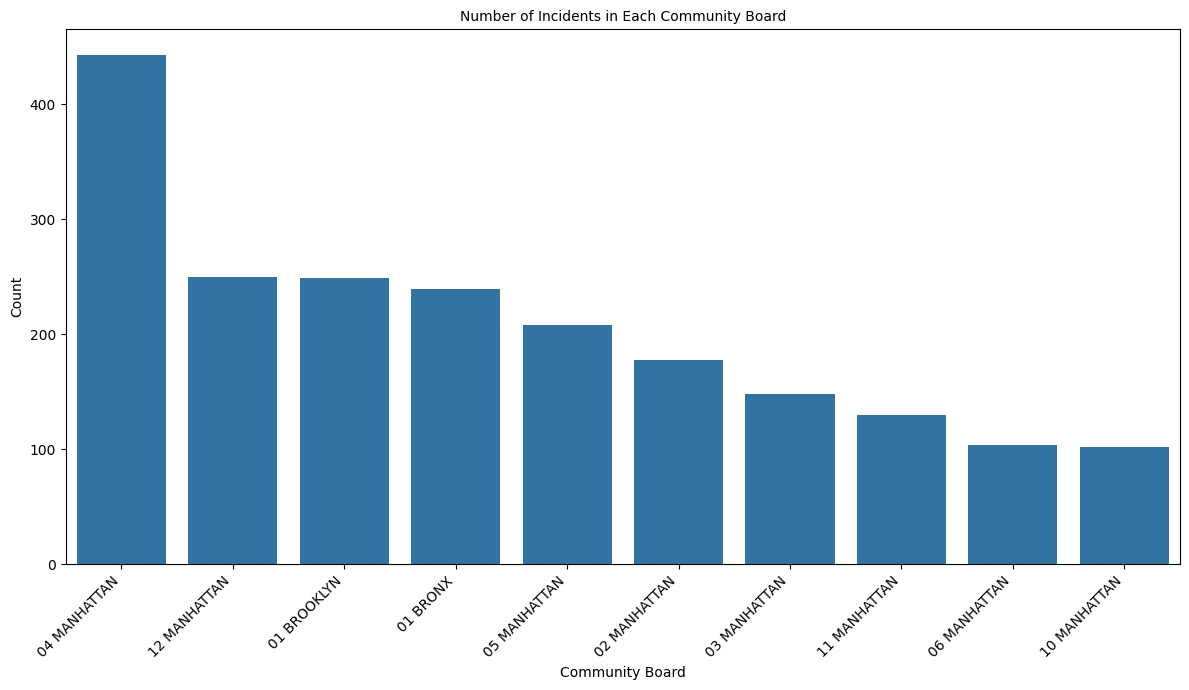

In [ ]:
top_community_boards = syringe_service_requests_df['Community Board'].value_counts().head(10)
plt.figure(figsize=(12, 7))
sns.barplot(x=top_community_boards.index, y=top_community_boards.values)
plt.title('Number of Incidents in Each Community Board', fontsize=10)
plt.xlabel('Community Board', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/tmp/ipython-input-4182024307.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.set_index('Created Date')


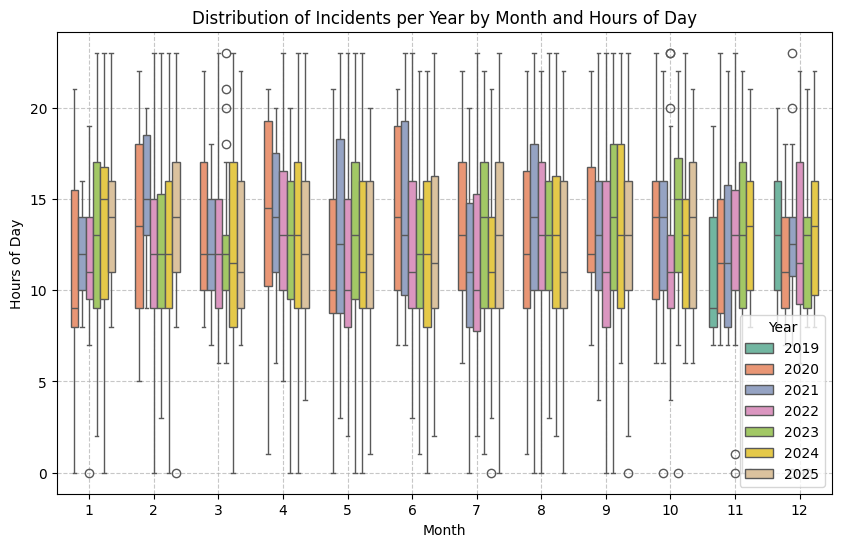

In [ ]:
syringe_service_requests_df['Day of Week Created'] = syringe_service_requests_df['Created Date'].dt.dayofweek
syringe_service_requests_df['Hour Created'] = syringe_service_requests_df['Created Date'].dt.hour
syringe_service_requests_df['Month Created'] = syringe_service_requests_df['Created Date'].dt.month
syringe_service_requests_df['Year Created'] = syringe_service_requests_df['Created Date'].dt.year
syringe_service_requests_df['Created on Start of Month'] = (syringe_service_requests_df['Created Date'].dt.day <= 15).astype(int)
syringe_service_requests_df['Created Early'] = syringe_service_requests_df['Hour Created'].between(0, 9).astype(int)

syringe_service_requests_df = syringe_service_requests_df.sort_values('Created Date')
syringe_service_requests_df['Prior Day Volume'] = (
    syringe_service_requests_df.set_index('Created Date')
    .rolling('1D', closed='left')['Borough']
    .count()
    .values
)
syringe_service_requests_df['Prior Day Volume'] = syringe_service_requests_df['Prior Day Volume'].fillna(0)

syringe_service_requests_df = syringe_service_requests_df.sort_values('Created Date')

syringe_service_requests_df['Prior Day Borough Volume'] = (
    syringe_service_requests_df
    .groupby('Borough', group_keys=False)
    .apply(lambda x: x.set_index('Created Date')
           .rolling('1D', closed='left')
           .count()
           .iloc[:, 0]
    )
    .reset_index(drop=True)
)

syringe_service_requests_df['Prior Day Borough Volume'] = syringe_service_requests_df['Prior Day Borough Volume'].fillna(0)

syringe_service_requests_df.drop(['Time Diff Between Resolution and Closed',
       'Time Diff Between Incident and Closed', 'Hours Between Incident and Resolution',
       'Minutes Between Incident and Resolution',
       'Seconds Between Incident and Resolution',
       'Days Between Resolution and Closed',
       'Hours Between Resolution and Closed',
       'Minutes Between Resolution and Closed',
       'Seconds Between Resolution and Closed',
       'Days Between Incident and Closed', 'Hours Between Incident and Closed',
       'Minutes Between Incident and Closed',
       'Seconds Between Incident and Closed', 'Created Date', 'Closed Date', 'Resolution Action Updated Date', 'Time Diff Between Incident and Resolution'], axis = 1, inplace = True)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Month Created', y='Hour Created', hue='Year Created', data=syringe_service_requests_df, palette='Set2')
plt.title('Distribution of Incidents per Year by Month and Hours of Day')
plt.xlabel('Month')
plt.ylabel('Hours of Day')
plt.legend(title='Year')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

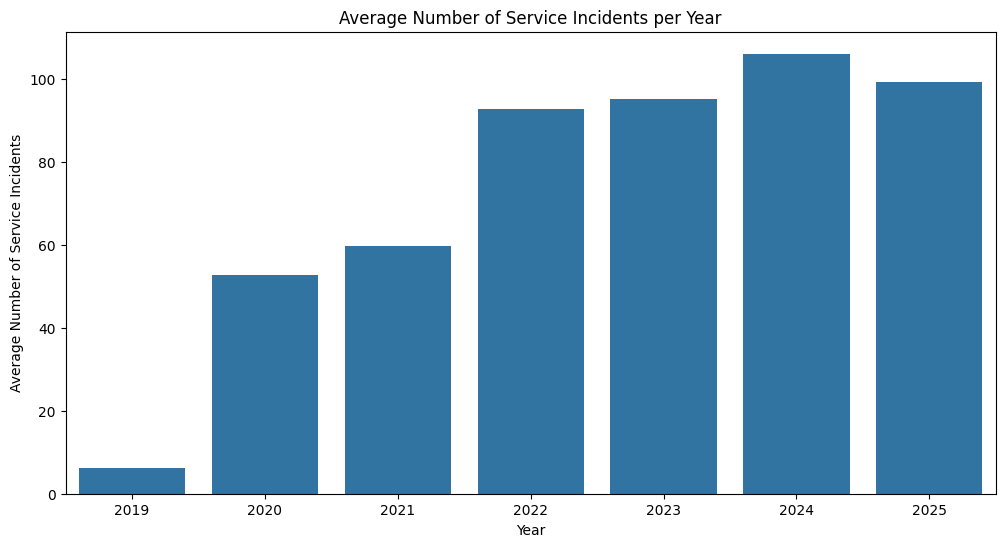

In [ ]:
average_incidents_per_year = syringe_service_requests_df.groupby('Year Created').size() / syringe_service_requests_df['Year Created'].nunique()

plt.figure(figsize=(12, 6))
sns.barplot(x=average_incidents_per_year.index, y=average_incidents_per_year)
plt.title('Average Number of Service Incidents per Year')
plt.xlabel('Year')
plt.ylabel('Average Number of Service Incidents')
plt.xticks(range(0, 7))
plt.show()

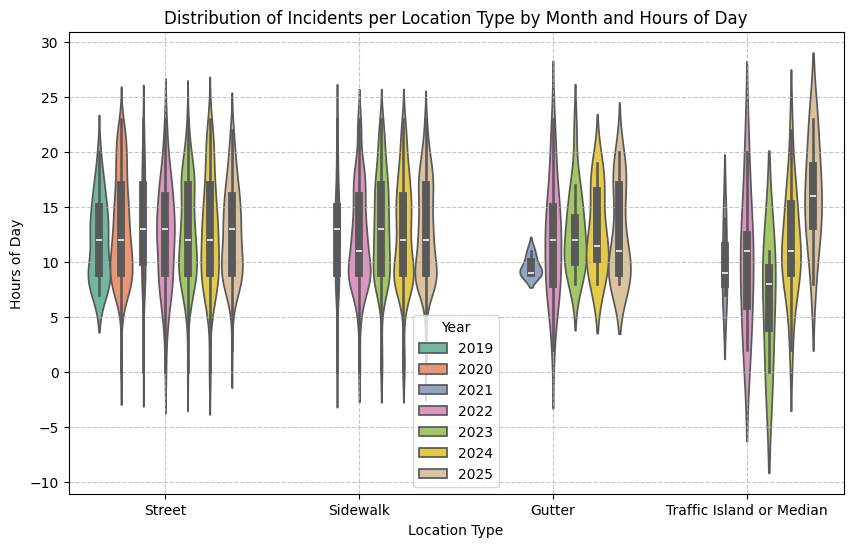

In [ ]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='Location Type', y='Hour Created', hue='Year Created', data=syringe_service_requests_df, palette='Set2')
plt.title('Distribution of Incidents per Location Type by Month and Hours of Day')
plt.xlabel('Location Type')
plt.ylabel('Hours of Day')
plt.legend(title='Year')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

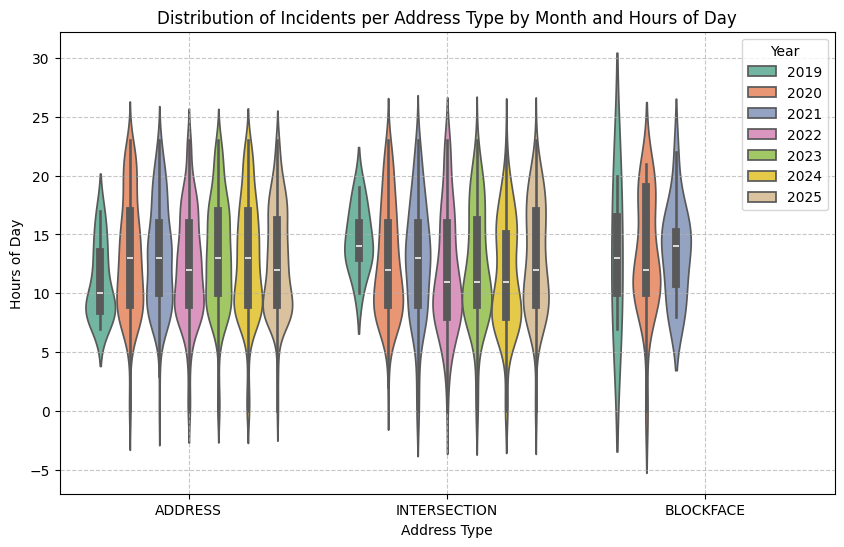

In [ ]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='Address Type', y='Hour Created', hue='Year Created', data=syringe_service_requests_df, palette='Set2')
plt.title('Distribution of Incidents per Address Type by Month and Hours of Day')
plt.xlabel('Address Type')
plt.ylabel('Hours of Day')
plt.legend(title='Year')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

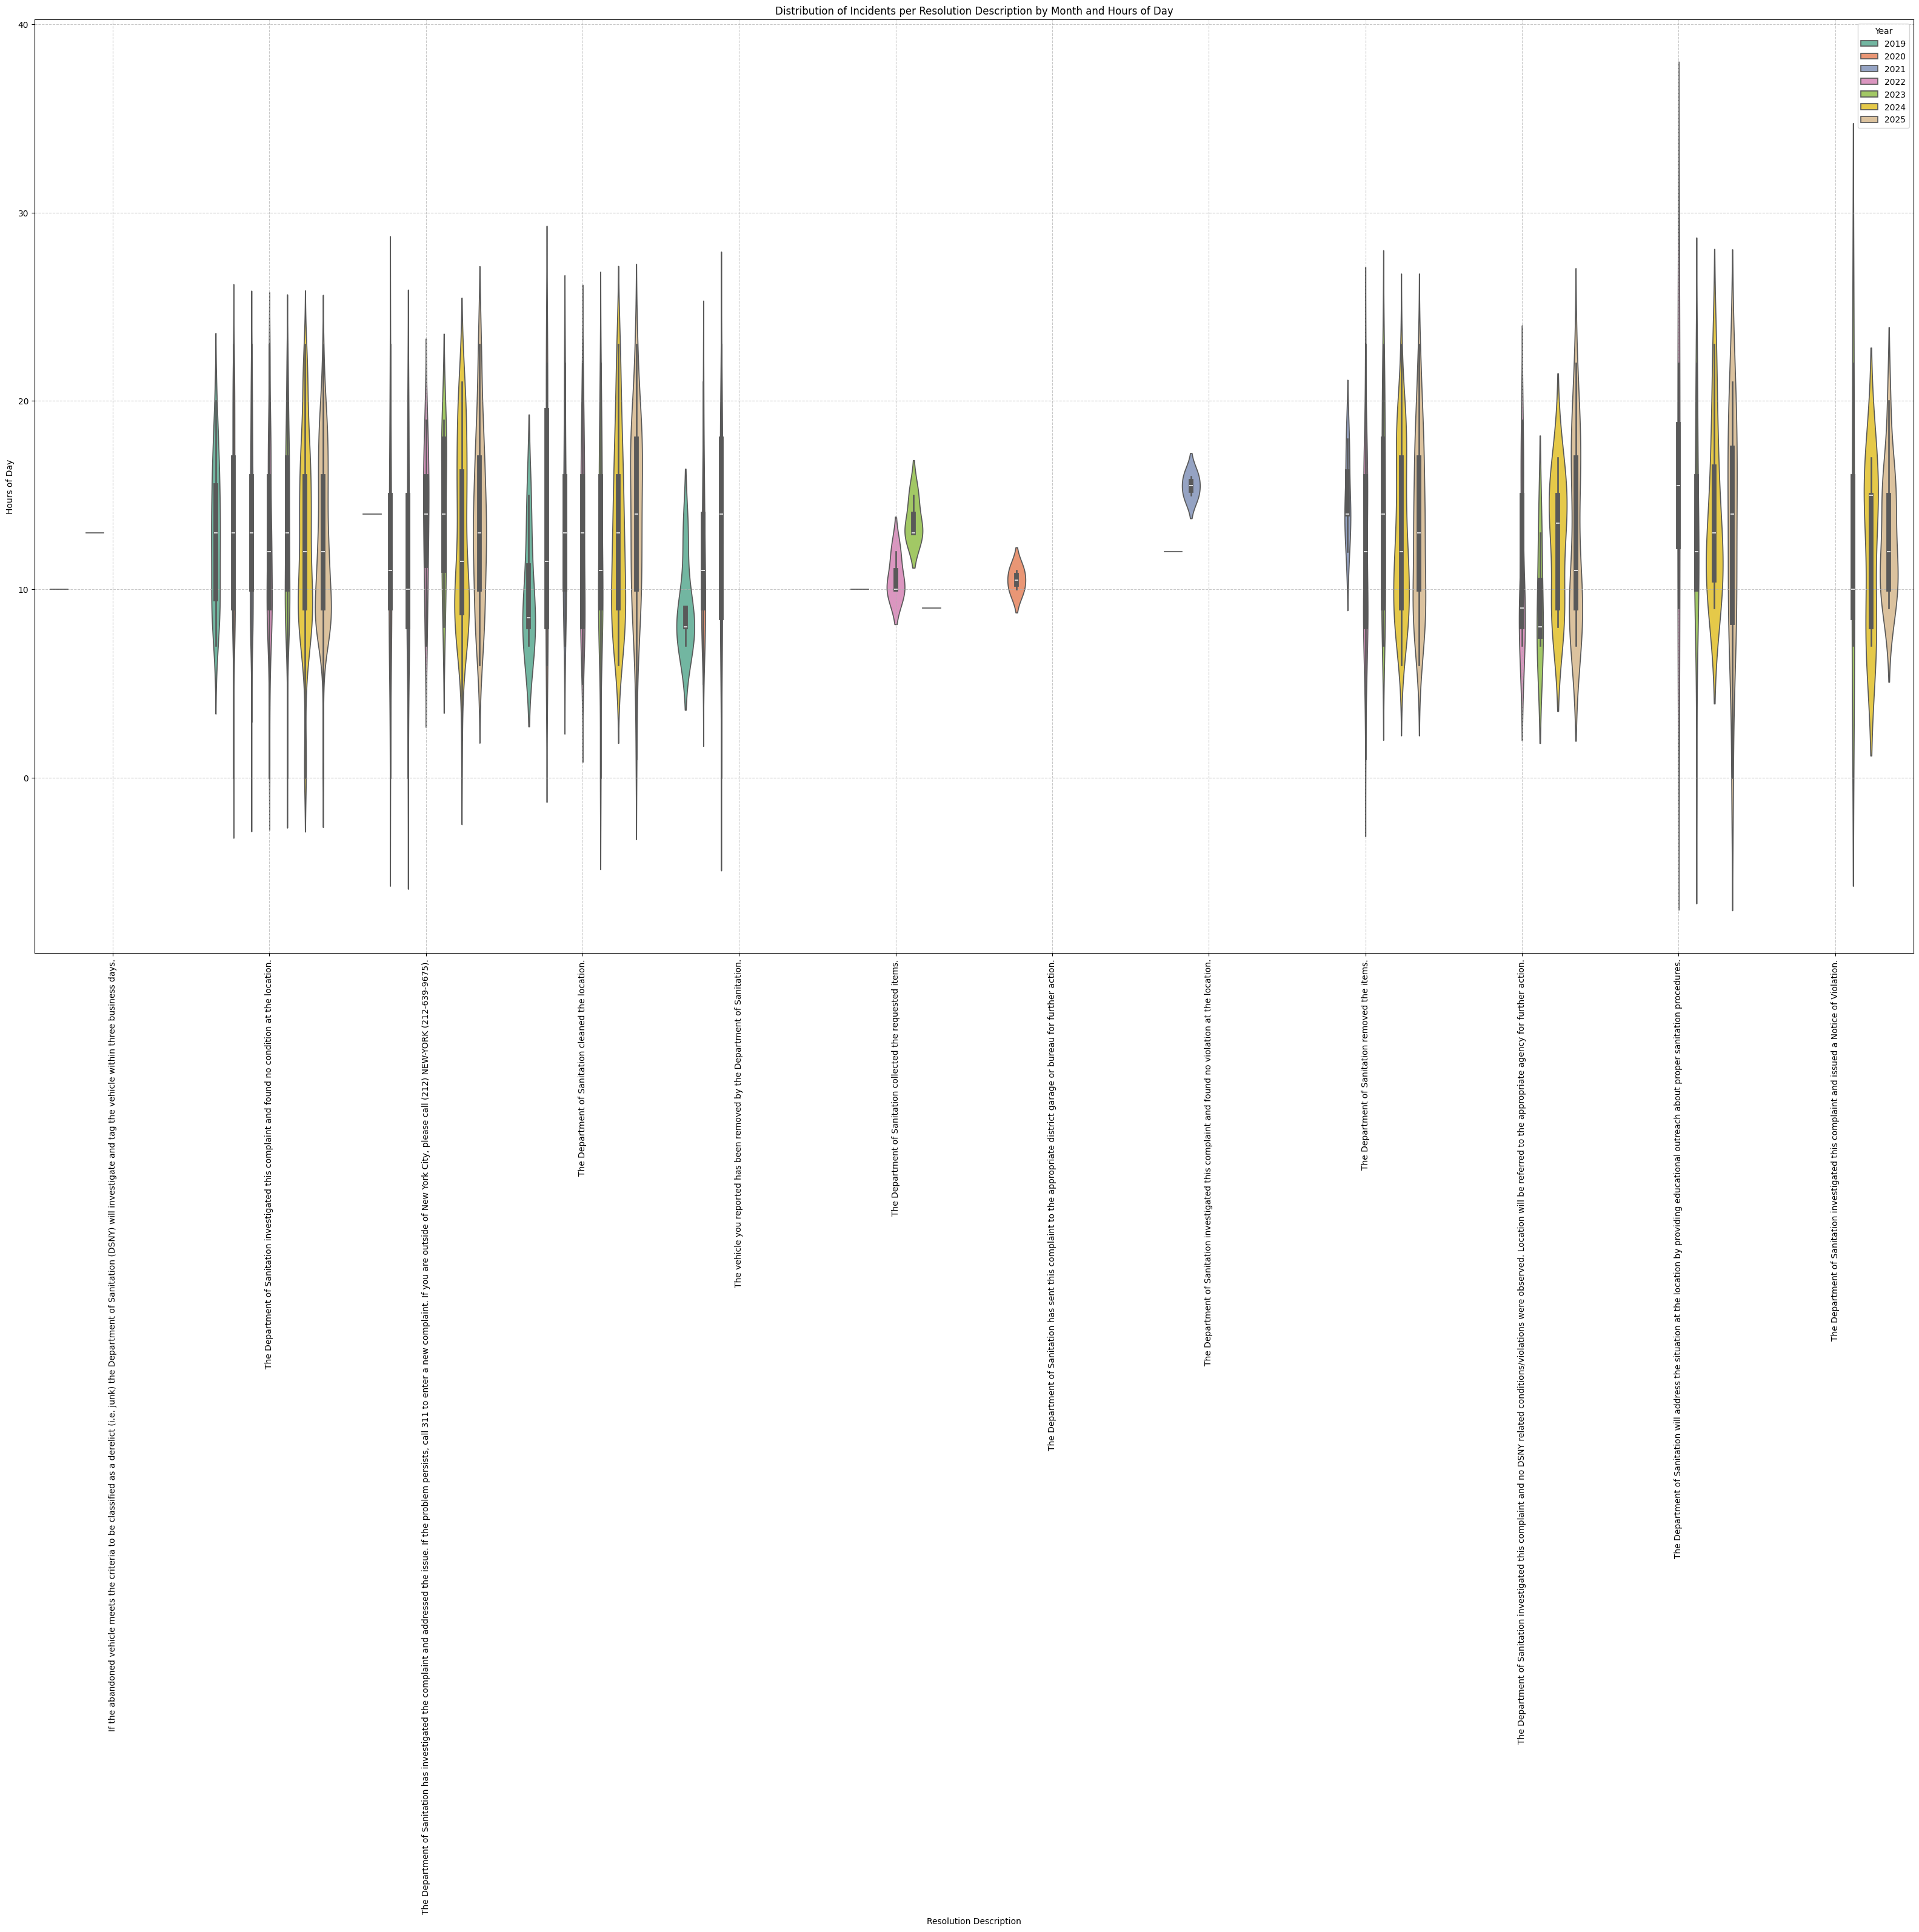

In [ ]:
plt.figure(figsize=(40, 20))
ax = sns.violinplot(x='Resolution Description', y='Hour Created', hue='Year Created', data=syringe_service_requests_df, palette='Set2')
ax.tick_params(axis='x', labelrotation=90)
plt.title('Distribution of Incidents per Resolution Description by Month and Hours of Day')
plt.xlabel('Resolution Description')
plt.ylabel('Hours of Day')
plt.legend(title='Year')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [ ]:
syringe_service_requests_df['Borough'].value_counts()

,count
Borough,
MANHATTAN,1766
BROOKLYN,765
BRONX,621
QUEENS,274
STATEN ISLAND,156


## Clustering to Identify Hotspots

In [ ]:
# help from gemini
syringe_service_requests_lat_long_df = syringe_service_requests_df.copy()
# https://www.datacamp.com/tutorial/dbscan-clustering-algorithm
fig = px.scatter_mapbox(
    syringe_service_requests_lat_long_df,
    lat='Latitude',
    lon='Longitude',
    hover_name='Borough',
    color='Borough',
    zoom=9,
    center={"lat": 40.7128, "lon": -74.0060},
    title="Location of Syringe Litter Service Requests"
)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})

fig.show()

In [ ]:
# source: https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/
kms_per_radian = 6371.0088
epsilon = 0.4 / kms_per_radian # ~ 5 NYC blocks convertunits.com/from/kilometers/to/city+block
coords = syringe_service_requests_lat_long_df[['Latitude', 'Longitude']].to_numpy()
db = DBSCAN(eps=epsilon, min_samples=10, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(-1, num_clusters-1)])
print('Number of clusters: {}'.format(num_clusters))
clusters_no_noise = clusters.drop(0)
def get_centermost_point(cluster):
  centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
  centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
  return tuple(centermost_point)
centermost_points = clusters_no_noise.map(get_centermost_point)
syringe_service_requests_no_clusters = syringe_service_requests_df.copy()
syringe_service_requests_df['Cluster'] = cluster_labels
centroids_df = pd.DataFrame(centermost_points.tolist(), columns=['Latitude', 'Longitude'])
centroids_df['Cluster'] = clusters_no_noise.index

syringe_service_requests_df['Cluster'] = syringe_service_requests_df['Cluster'].astype(str)
cluster_counts = syringe_service_requests_df['Cluster'].value_counts()
sorted_clusters = cluster_counts.index.tolist()
if '-1' in sorted_clusters:
    sorted_clusters.remove('-1')
    sorted_clusters.append('-1')

fig = px.scatter_mapbox(
    syringe_service_requests_df,
    lat='Latitude',
    lon='Longitude',
    hover_name='Borough',
    color=syringe_service_requests_df['Cluster'].astype(str),
    zoom=9,
    center={"lat": 40.7128, "lon": -74.0060},
    title="Location of Syringe Litter Service Requests",
    labels={"color": "Cluster"},
    category_orders={"Cluster": sorted_clusters},
    color_discrete_sequence=px.colors.qualitative.Alphabet
)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.update_layout(
    legend=dict(
        traceorder="normal",
        font=dict(size=10),
        itemsizing='constant',
        entrywidth=70,
        entrywidthmode="pixels",
        orientation="h",
        yanchor="top",
        y=-0.1,
        xanchor="left",
        x=0
    )
)
fig.for_each_trace(lambda t: t.update(marker=dict(opacity=0.3)) if t.name == "-1" else ())
fig.show()

Number of clusters: 31


In [ ]:
syringe_service_requests_no_clusters = syringe_service_requests_df.copy()
syringe_service_requests_df['Cluster'] = cluster_labels
centroids_df = pd.DataFrame(centermost_points.tolist(), columns=['Latitude', 'Longitude'])
centroids_df['Cluster'] = clusters_no_noise.index
syringe_service_requests_df['Cluster'] = syringe_service_requests_df['Cluster'].astype(str)
cluster_counts = syringe_service_requests_df['Cluster'].value_counts()
sorted_clusters = cluster_counts.index.tolist()
if '-1' in sorted_clusters:
    sorted_clusters.remove('-1')
    sorted_clusters.append('-1')

fig = px.scatter_mapbox(
    syringe_service_requests_df,
    lat='Latitude',
    lon='Longitude',
    hover_name='Borough',
    color=syringe_service_requests_df['Cluster'].astype(str),
    zoom=9,
    center={"lat": 40.7128, "lon": -74.0060},
    title="Location of Syringe Litter Service Requests",
    labels={"color": "Cluster"},
    category_orders={"Cluster": sorted_clusters},
    color_discrete_sequence=px.colors.qualitative.Alphabet
)

fig.add_trace(go.Scattermapbox(
    lat=centroids_df['Latitude'],
    lon=centroids_df['Longitude'],
    mode='markers',
    marker=go.scattermapbox.Marker(
        size=15,
        color='black',
        symbol='circle',
        opacity=0.5
    ),
    text=centroids_df['Cluster'],
    hoverinfo='text',
    name='Cluster Center'
))

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.update_layout(
    legend=dict(
        traceorder="normal",
        font=dict(size=10),
        itemsizing='constant',
        entrywidth=70,
        entrywidthmode="pixels",
        orientation="h",
        yanchor="top",
        y=-0.1,
        xanchor="left",
        x=0
    )
)
fig.for_each_trace(lambda t: t.update(marker=dict(opacity=0.3)) if t.name == "-1" else ())
fig.show()

In [ ]:
syringe_service_requests_df[syringe_service_requests_df['Cluster'] == '24']['Resolution Description'].value_counts()

,count
Resolution Description,
The Department of Sanitation investigated this complaint and found no condition at the location.,9
The Department of Sanitation removed the items.,1


In [ ]:
syringe_service_requests_lat_long_2019_df = syringe_service_requests_lat_long_df[syringe_service_requests_lat_long_df['Year Created'] == 2019]
syringe_service_requests_lat_long_2020_df = syringe_service_requests_lat_long_df[syringe_service_requests_lat_long_df['Year Created'] == 2020]
syringe_service_requests_lat_long_2021_df = syringe_service_requests_lat_long_df[syringe_service_requests_lat_long_df['Year Created'] == 2021]
syringe_service_requests_lat_long_2022_df = syringe_service_requests_lat_long_df[syringe_service_requests_lat_long_df['Year Created'] == 2022]
syringe_service_requests_lat_long_2023_df = syringe_service_requests_lat_long_df[syringe_service_requests_lat_long_df['Year Created'] == 2023]
syringe_service_requests_lat_long_2024_df = syringe_service_requests_lat_long_df[syringe_service_requests_lat_long_df['Year Created'] == 2024]
syringe_service_requests_lat_long_2025_df = syringe_service_requests_lat_long_df[syringe_service_requests_lat_long_df['Year Created'] == 2025]

kms_per_radian = 6371.0088
epsilon = 0.6 / kms_per_radian # ~ 7.5 NYC blocks convertunits.com/from/kilometers/to/city+block
coords = syringe_service_requests_lat_long_2019_df[['Latitude', 'Longitude']].to_numpy()
db = DBSCAN(eps=epsilon, min_samples=10, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(-1, num_clusters-1)])
print('Number of clusters: {}'.format(num_clusters))
clusters_no_noise = clusters.drop(0)
centermost_points = clusters_no_noise.map(get_centermost_point)
syringe_service_requests_lat_long_2019_df['Cluster'] = cluster_labels
centroids_df = pd.DataFrame(centermost_points.tolist(), columns=['Latitude', 'Longitude'])
centroids_df['Cluster'] = clusters_no_noise.index
fig = px.scatter_mapbox(
    syringe_service_requests_lat_long_2019_df,
    lat='Latitude',
    lon='Longitude',
    hover_name='Borough',
    color=syringe_service_requests_lat_long_2019_df['Cluster'].astype(str),
    zoom=9,
    center={"lat": 40.7128, "lon": -74.0060},
    title="Location of Syringe Litter Service Requests in 2019",
    color_discrete_sequence=px.colors.qualitative.Dark24,
    labels={"color": "Cluster"},
    category_orders={"color": ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "-1"]}
)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})

fig.show()

Number of clusters: 2


/tmp/ipython-input-2378653668.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
kms_per_radian = 6371.0088
epsilon = 0.6 / kms_per_radian # ~ 7.5 NYC blocks convertunits.com/from/kilometers/to/city+block
coords = syringe_service_requests_lat_long_2020_df[['Latitude', 'Longitude']].to_numpy()
db = DBSCAN(eps=epsilon, min_samples=10, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(-1, num_clusters-1)])
print('Number of clusters: {}'.format(num_clusters))
clusters_no_noise = clusters.drop(0)
centermost_points = clusters_no_noise.map(get_centermost_point)
syringe_service_requests_lat_long_2020_df['Cluster'] = cluster_labels
centroids_df = pd.DataFrame(centermost_points.tolist(), columns=['Latitude', 'Longitude'])
centroids_df['Cluster'] = clusters_no_noise.index
fig = px.scatter_mapbox(
    syringe_service_requests_lat_long_2020_df,
    lat='Latitude',
    lon='Longitude',
    hover_name='Borough',
    color=syringe_service_requests_lat_long_2020_df['Cluster'].astype(str),
    zoom=9,
    center={"lat": 40.7128, "lon": -74.0060},
    title="Location of Syringe Litter Service Requests in 2019",
    color_discrete_sequence=px.colors.qualitative.Dark24,
    labels={"color": "Cluster"},
    category_orders={"color": ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "-1"]}
)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})

fig.show()

Number of clusters: 5


/tmp/ipython-input-2463312797.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
kms_per_radian = 6371.0088
epsilon = 0.6 / kms_per_radian # ~ 7.5 NYC blocks convertunits.com/from/kilometers/to/city+block
coords = syringe_service_requests_lat_long_2021_df[['Latitude', 'Longitude']].to_numpy()
db = DBSCAN(eps=epsilon, min_samples=10, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(-1, num_clusters-1)])
print('Number of clusters: {}'.format(num_clusters))
clusters_no_noise = clusters.drop(0)
centermost_points = clusters_no_noise.map(get_centermost_point)
syringe_service_requests_lat_long_2021_df['Cluster'] = cluster_labels
centroids_df = pd.DataFrame(centermost_points.tolist(), columns=['Latitude', 'Longitude'])
centroids_df['Cluster'] = clusters_no_noise.index
fig = px.scatter_mapbox(
    syringe_service_requests_lat_long_2021_df,
    lat='Latitude',
    lon='Longitude',
    hover_name='Borough',
    color=syringe_service_requests_lat_long_2021_df['Cluster'].astype(str),
    zoom=9,
    center={"lat": 40.7128, "lon": -74.0060},
    title="Location of Syringe Litter Service Requests in 2019",
    color_discrete_sequence=px.colors.qualitative.Dark24,
    labels={"color": "Cluster"},
    category_orders={"color": ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "-1"]}
)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})

fig.show()

Number of clusters: 8


/tmp/ipython-input-128415095.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
kms_per_radian = 6371.0088
epsilon = 0.6 / kms_per_radian # ~ 7.5 NYC blocks convertunits.com/from/kilometers/to/city+block
coords = syringe_service_requests_lat_long_2022_df[['Latitude', 'Longitude']].to_numpy()
db = DBSCAN(eps=epsilon, min_samples=10, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(-1, num_clusters-1)])
print('Number of clusters: {}'.format(num_clusters))
clusters_no_noise = clusters.drop(0)
centermost_points = clusters_no_noise.map(get_centermost_point)
syringe_service_requests_lat_long_2022_df['Cluster'] = cluster_labels
centroids_df = pd.DataFrame(centermost_points.tolist(), columns=['Latitude', 'Longitude'])
centroids_df['Cluster'] = clusters_no_noise.index
fig = px.scatter_mapbox(
    syringe_service_requests_lat_long_2022_df,
    lat='Latitude',
    lon='Longitude',
    hover_name='Borough',
    color=syringe_service_requests_lat_long_2022_df['Cluster'].astype(str),
    zoom=9,
    center={"lat": 40.7128, "lon": -74.0060},
    title="Location of Syringe Litter Service Requests in 2019",
    color_discrete_sequence=px.colors.qualitative.Dark24,
    labels={"color": "Cluster"},
    category_orders={"color": ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "-1"]}
)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})

fig.show()

Number of clusters: 9


/tmp/ipython-input-1580843470.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
kms_per_radian = 6371.0088
epsilon = 0.6 / kms_per_radian # ~ 7.5 NYC blocks convertunits.com/from/kilometers/to/city+block
coords = syringe_service_requests_lat_long_2023_df[['Latitude', 'Longitude']].to_numpy()
db = DBSCAN(eps=epsilon, min_samples=10, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(-1, num_clusters-1)])
print('Number of clusters: {}'.format(num_clusters))
clusters_no_noise = clusters.drop(0)
centermost_points = clusters_no_noise.map(get_centermost_point)
syringe_service_requests_lat_long_2023_df['Cluster'] = cluster_labels
centroids_df = pd.DataFrame(centermost_points.tolist(), columns=['Latitude', 'Longitude'])
centroids_df['Cluster'] = clusters_no_noise.index
fig = px.scatter_mapbox(
    syringe_service_requests_lat_long_2023_df,
    lat='Latitude',
    lon='Longitude',
    hover_name='Borough',
    color=syringe_service_requests_lat_long_2023_df['Cluster'].astype(str),
    zoom=9,
    center={"lat": 40.7128, "lon": -74.0060},
    title="Location of Syringe Litter Service Requests in 2019",
    color_discrete_sequence=px.colors.qualitative.Dark24,
    labels={"color": "Cluster"},
    category_orders={"color": ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "-1"]}
)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})

fig.show()

Number of clusters: 10


/tmp/ipython-input-396153042.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
kms_per_radian = 6371.0088
epsilon = 0.6 / kms_per_radian # ~ 7.5 NYC blocks convertunits.com/from/kilometers/to/city+block
coords = syringe_service_requests_lat_long_2024_df[['Latitude', 'Longitude']].to_numpy()
db = DBSCAN(eps=epsilon, min_samples=10, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(-1, num_clusters-1)])
print('Number of clusters: {}'.format(num_clusters))
clusters_no_noise = clusters.drop(0)
centermost_points = clusters_no_noise.map(get_centermost_point)
syringe_service_requests_lat_long_2024_df['Cluster'] = cluster_labels
centroids_df = pd.DataFrame(centermost_points.tolist(), columns=['Latitude', 'Longitude'])
centroids_df['Cluster'] = clusters_no_noise.index
fig = px.scatter_mapbox(
    syringe_service_requests_lat_long_2024_df,
    lat='Latitude',
    lon='Longitude',
    hover_name='Borough',
    color=syringe_service_requests_lat_long_2024_df['Cluster'].astype(str),
    zoom=9,
    center={"lat": 40.7128, "lon": -74.0060},
    title="Location of Syringe Litter Service Requests in 2019",
    color_discrete_sequence=px.colors.qualitative.Dark24,
    labels={"color": "Cluster"},
    category_orders={"color": ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "-1"]}
)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})

fig.show()

Number of clusters: 12


/tmp/ipython-input-1687983508.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
kms_per_radian = 6371.0088
epsilon = 0.6 / kms_per_radian # ~ 7.5 NYC blocks convertunits.com/from/kilometers/to/city+block
coords = syringe_service_requests_lat_long_2025_df[['Latitude', 'Longitude']].to_numpy()
db = DBSCAN(eps=epsilon, min_samples=10, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(-1, num_clusters-1)])
print('Number of clusters: {}'.format(num_clusters))
clusters_no_noise = clusters.drop(0)
centermost_points = clusters_no_noise.map(get_centermost_point)
syringe_service_requests_lat_long_2025_df['Cluster'] = cluster_labels
centroids_df = pd.DataFrame(centermost_points.tolist(), columns=['Latitude', 'Longitude'])
centroids_df['Cluster'] = clusters_no_noise.index
fig = px.scatter_mapbox(
    syringe_service_requests_lat_long_2025_df,
    lat='Latitude',
    lon='Longitude',
    hover_name='Borough',
    color=syringe_service_requests_lat_long_2025_df['Cluster'].astype(str),
    zoom=9,
    center={"lat": 40.7128, "lon": -74.0060},
    title="Location of Syringe Litter Service Requests in 2019",
    color_discrete_sequence=px.colors.qualitative.Dark24,
    labels={"color": "Cluster"},
    category_orders={"color": ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "-1"]}
)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})

fig.show()

/tmp/ipython-input-2317472659.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Number of clusters: 15


## Exploratory Data Analysis

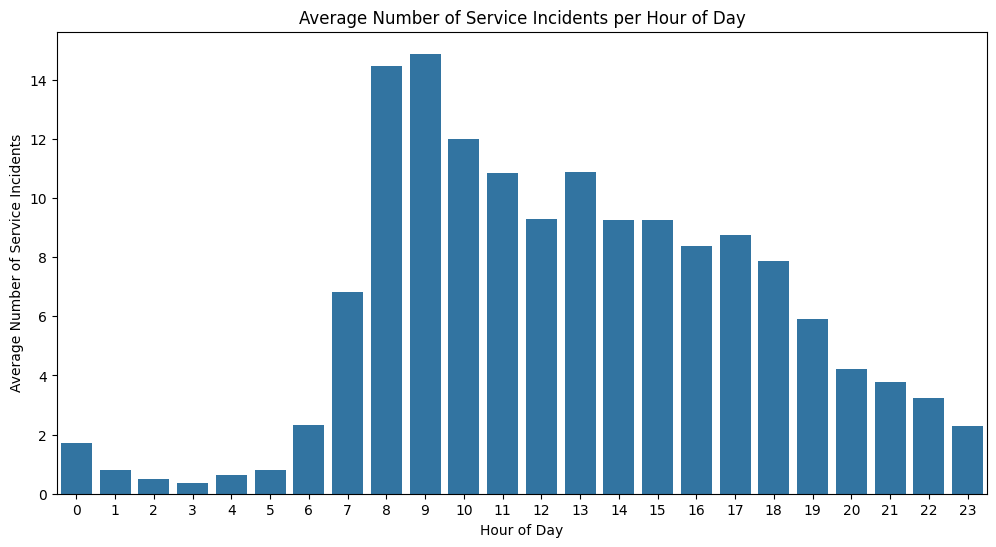

In [ ]:
average_crashes_per_hour = syringe_service_requests_df.groupby('Hour Created').size() / syringe_service_requests_df['Hour Created'].nunique()
plt.figure(figsize=(12, 6))
sns.barplot(x=average_crashes_per_hour.index, y=average_crashes_per_hour)
plt.title('Average Number of Service Incidents per Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Number of Service Incidents')
plt.xticks(range(0, 24))
plt.show()

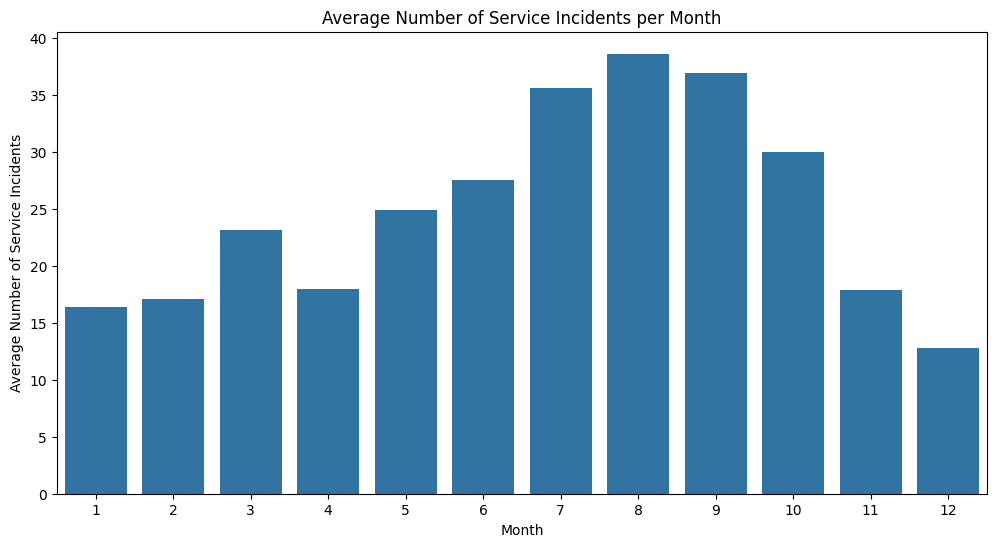

In [ ]:
average_incidents_per_month = syringe_service_requests_df.groupby('Month Created').size() / syringe_service_requests_df['Month Created'].nunique()

plt.figure(figsize=(12, 6))
sns.barplot(x=average_incidents_per_month.index, y=average_incidents_per_month)
plt.title('Average Number of Service Incidents per Month')
plt.xlabel('Month')
plt.ylabel('Average Number of Service Incidents')
plt.xticks(range(0, 12))
plt.show()

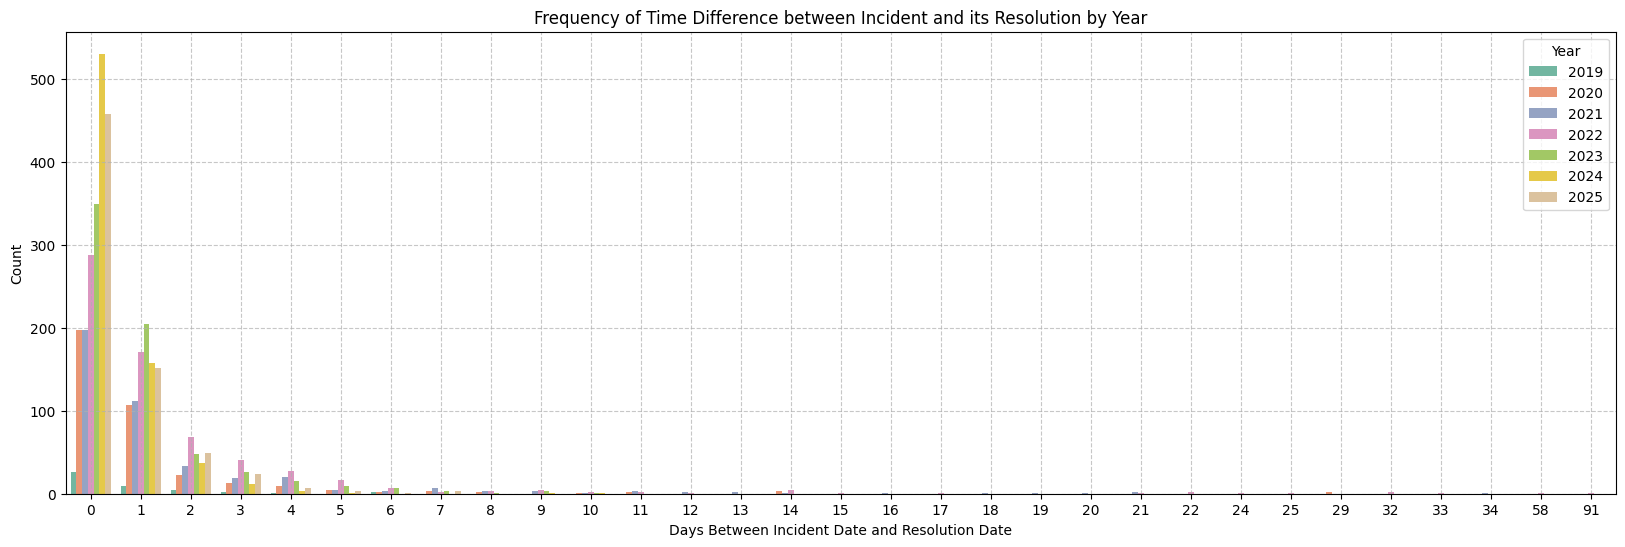

In [ ]:
plt.figure(figsize=(20, 6))
sns.countplot(x='Days Between Incident and Resolution', data=syringe_service_requests_df, hue='Year Created', palette='Set2')
plt.title('Frequency of Time Difference between Incident and its Resolution by Year')
plt.xlabel('Days Between Incident Date and Resolution Date')
plt.ylabel('Count')
plt.legend(title='Year')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

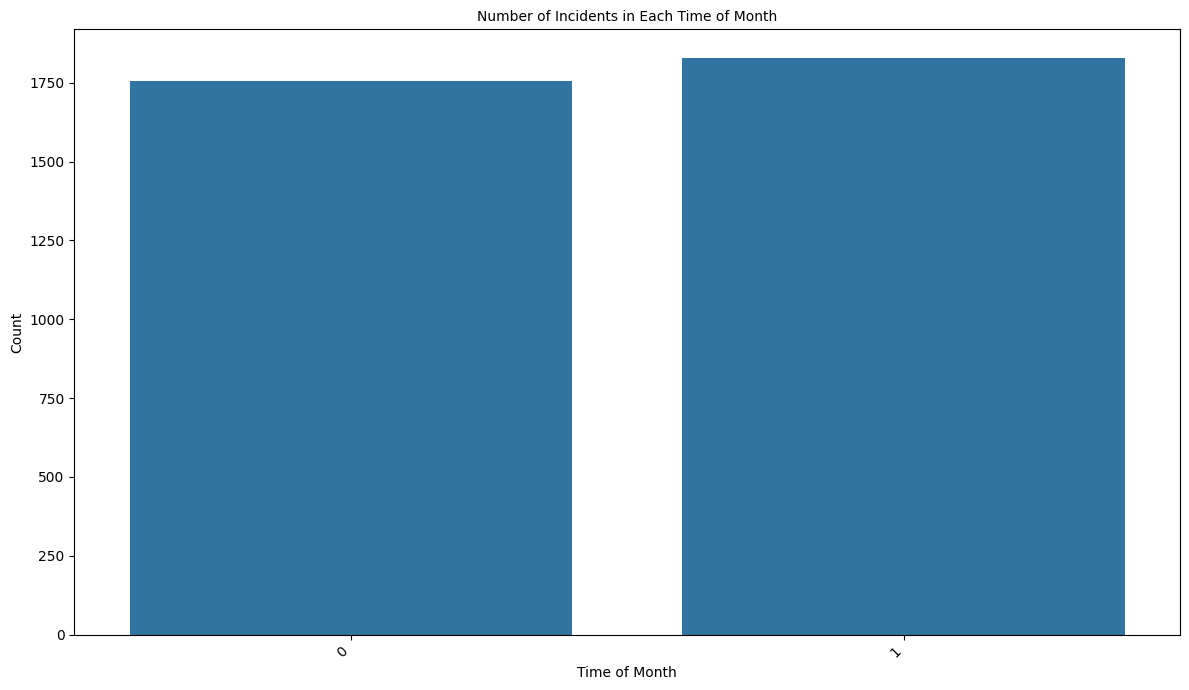

In [ ]:
top_times_of_month = syringe_service_requests_df['Created on Start of Month'].value_counts()
plt.figure(figsize=(12, 7))
sns.barplot(x=top_times_of_month.index, y=top_times_of_month.values)
plt.title('Number of Incidents in Each Time of Month', fontsize=10)
plt.xlabel('Time of Month', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

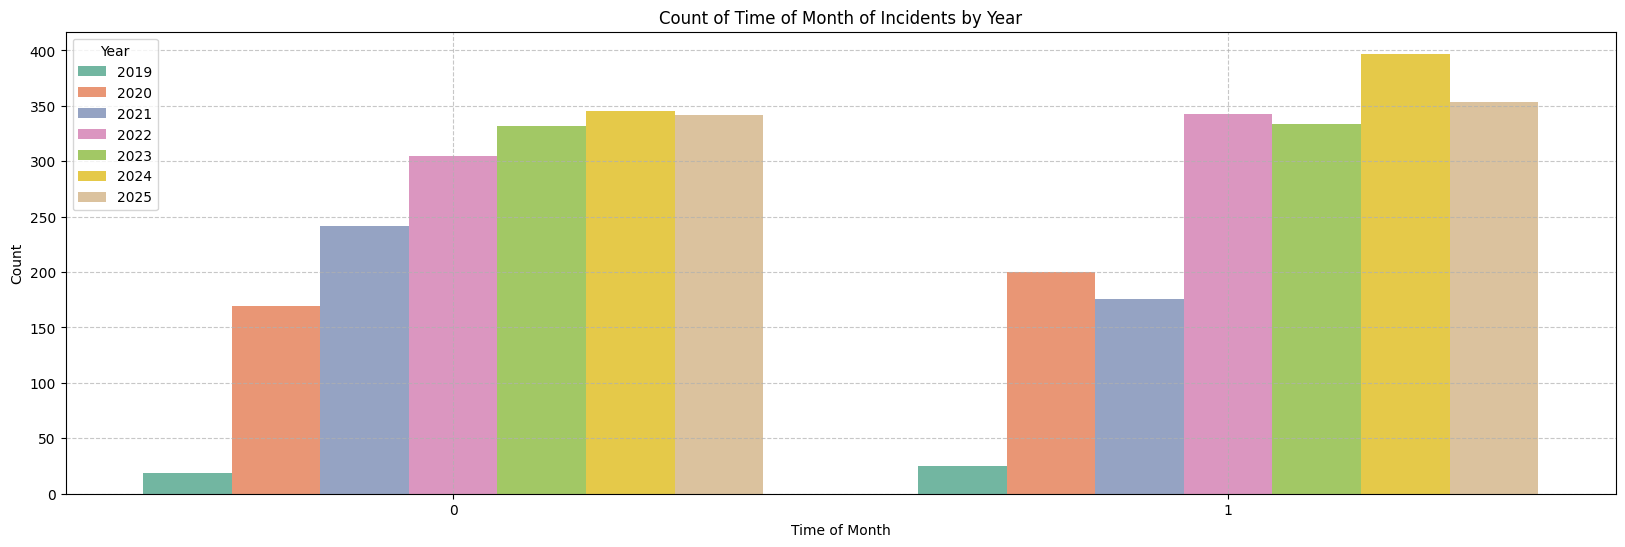

In [ ]:
plt.figure(figsize=(20, 6))
sns.countplot(x='Created on Start of Month', data=syringe_service_requests_df, hue='Year Created', palette='Set2')
plt.title('Count of Time of Month of Incidents by Year')
plt.xlabel('Time of Month')
plt.ylabel('Count')
plt.legend(title='Year')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

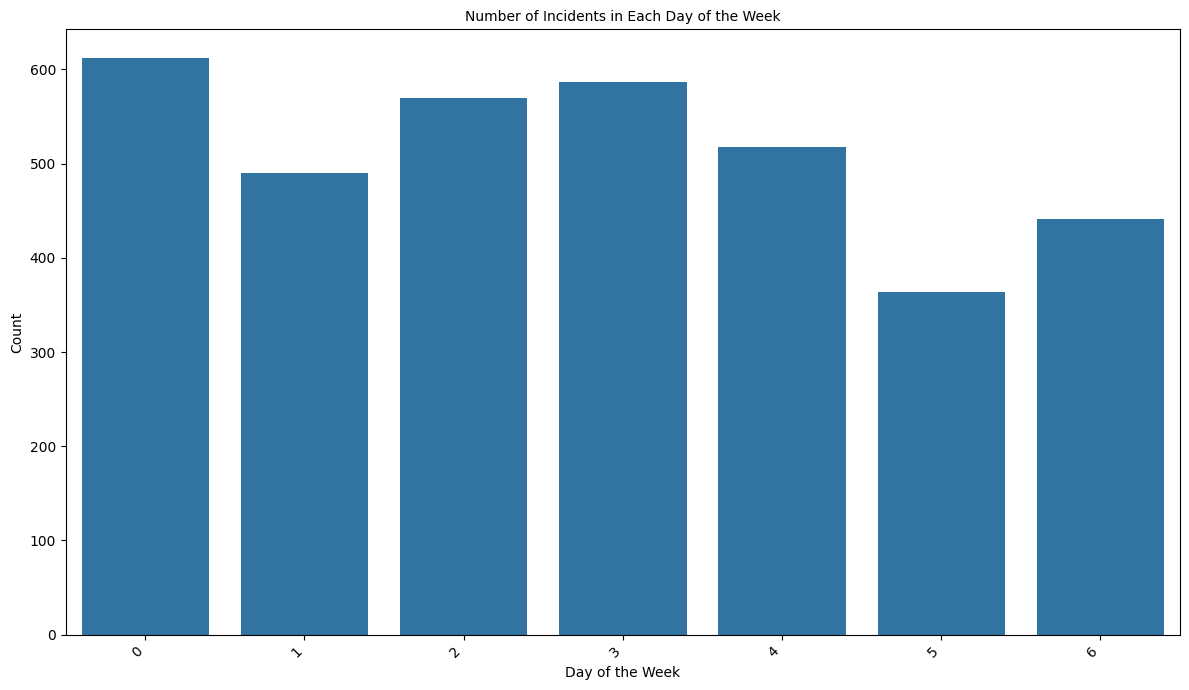

In [ ]:
top_day_of_week = syringe_service_requests_df['Day of Week Created'].value_counts()
plt.figure(figsize=(12, 7))
sns.barplot(x=top_day_of_week.index, y=top_day_of_week.values)
plt.title('Number of Incidents in Each Day of the Week', fontsize=10)
plt.xlabel('Day of the Week', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

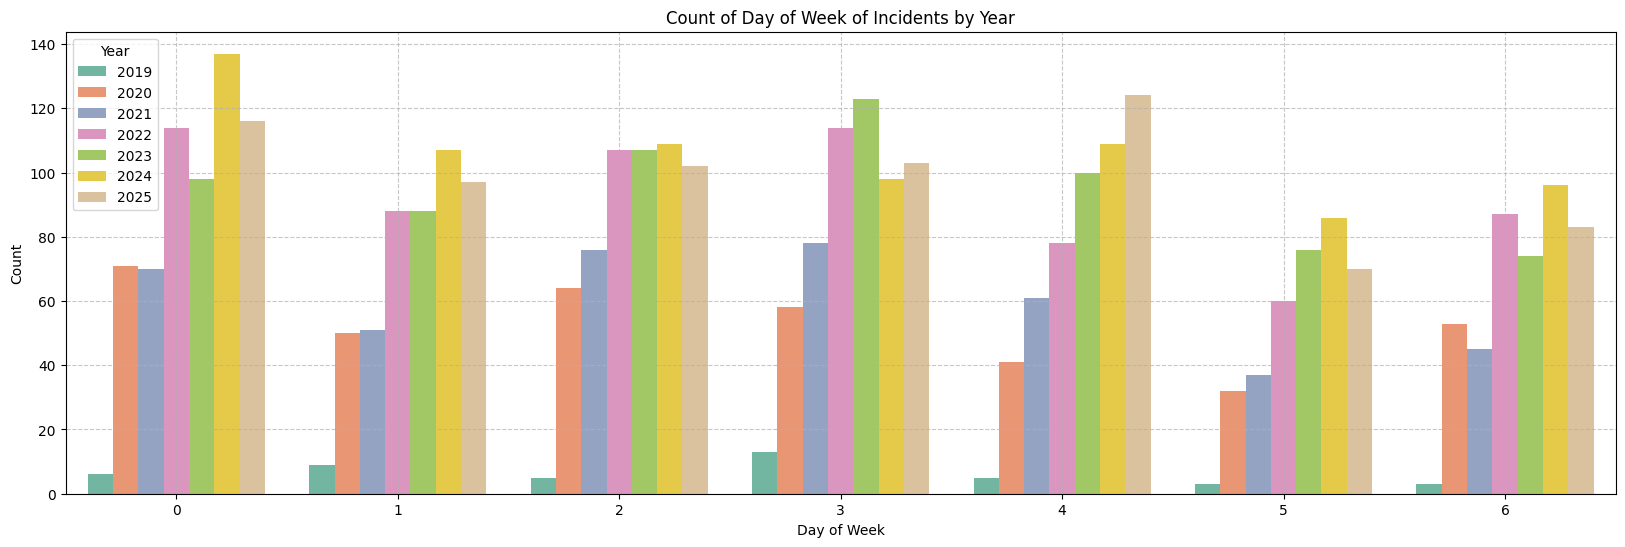

In [ ]:
plt.figure(figsize=(20, 6))
sns.countplot(x='Day of Week Created', data=syringe_service_requests_df, hue='Year Created', palette='Set2')
plt.title('Count of Day of Week of Incidents by Year')
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.legend(title='Year')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

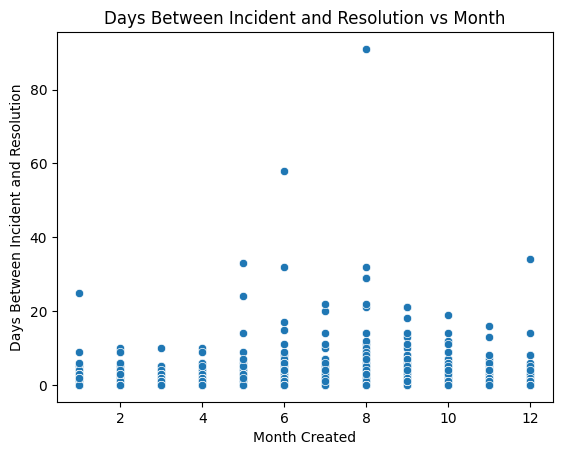

In [ ]:
sns.scatterplot(x="Month Created", y="Days Between Incident and Resolution", data=syringe_service_requests_df)
plt.title("Days Between Incident and Resolution vs Month")
plt.show()

## Regression to Predict Number of Days Until Resolution

In [ ]:
syringe_service_requests_incident_resolution_df = syringe_service_requests_df.copy()
data_leakage_and_overlapping_cols = ['Latitude', 'Longitude', 'Resolution Description']
similar_cols = ['Created Early', 'Incident Zip', 'Community Board', 'Borough', 'Created Early']
syringe_service_requests_incident_resolution_df = syringe_service_requests_incident_resolution_df.drop(columns = data_leakage_and_overlapping_cols, axis = 1)
syringe_service_requests_incident_resolution_df = syringe_service_requests_incident_resolution_df.drop(columns = similar_cols, axis = 1)
categorical_cols = ['Location Type', 'Address Type', 'Day of Week Created', 'Created on Start of Month', 'Cluster', 'Year Created']
syringe_service_requests_incident_resolution_df = pd.get_dummies(syringe_service_requests_incident_resolution_df, columns=categorical_cols, drop_first=True, dtype=int)
syringe_service_requests_incident_resolution_df.drop('Location Type_Street', axis = 1, inplace = True)
ordinal_cols = ['Month Created', 'Hour Created', 'Prior Day Volume', 'Prior Day Borough Volume']
scaled_df = syringe_service_requests_incident_resolution_df.copy()
scaled_df[ordinal_cols] = StandardScaler().fit_transform(scaled_df[ordinal_cols])
scaled_df = scaled_df.groupby('Days Between Incident and Resolution').filter(lambda x: len(x) > 1)
X = scaled_df.drop('Days Between Incident and Resolution', axis = 1)
y = scaled_df['Days Between Incident and Resolution']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=2)

In [ ]:
X_train.columns

Index(['Hour Created', 'Month Created', 'Prior Day Volume',
       'Prior Day Borough Volume', 'Location Type_Sidewalk',
       'Location Type_Traffic Island or Median', 'Address Type_BLOCKFACE',
       'Address Type_INTERSECTION', 'Day of Week Created_1',
       'Day of Week Created_2', 'Day of Week Created_3',
       'Day of Week Created_4', 'Day of Week Created_5',
       'Day of Week Created_6', 'Created on Start of Month_1', 'Cluster_0',
       'Cluster_1', 'Cluster_10', 'Cluster_11', 'Cluster_12', 'Cluster_13',
       'Cluster_14', 'Cluster_15', 'Cluster_16', 'Cluster_17', 'Cluster_18',
       'Cluster_19', 'Cluster_2', 'Cluster_20', 'Cluster_21', 'Cluster_22',
       'Cluster_23', 'Cluster_24', 'Cluster_25', 'Cluster_26', 'Cluster_27',
       'Cluster_28', 'Cluster_29', 'Cluster_3', 'Cluster_4', 'Cluster_5',
       'Cluster_6', 'Cluster_7', 'Cluster_8', 'Cluster_9', 'Year Created_2020',
       'Year Created_2021', 'Year Created_2022', 'Year Created_2023',
       'Year Created_20

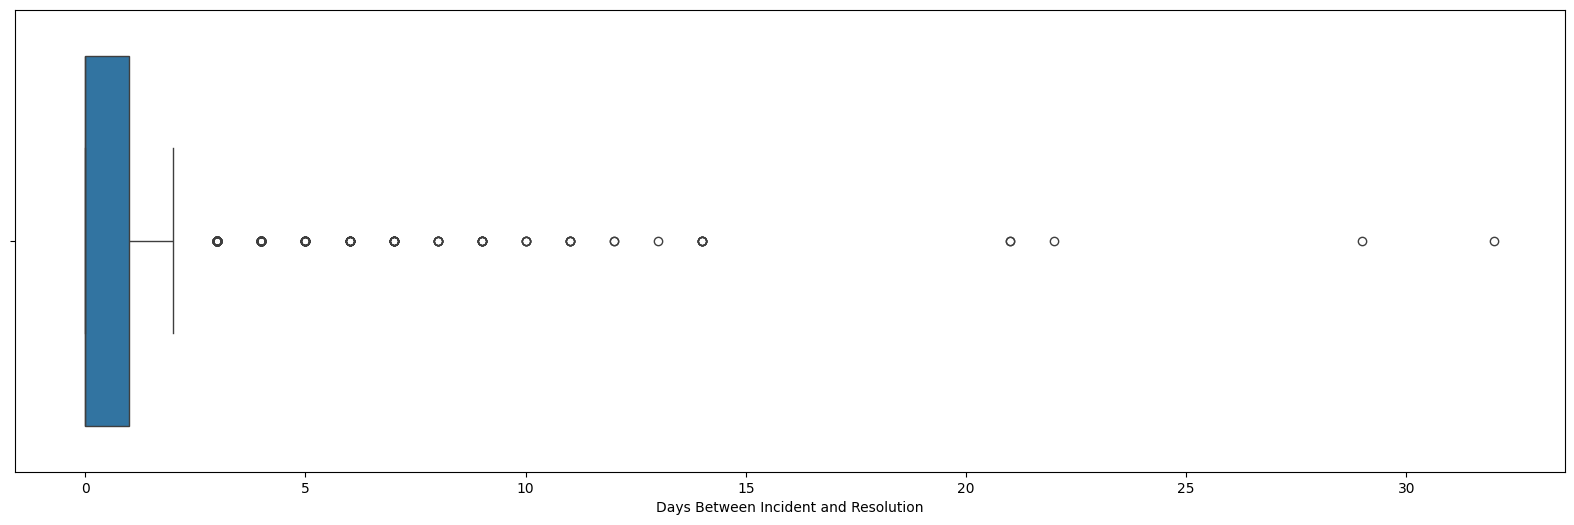

In [ ]:
plt.figure(figsize=(20, 6))
sns.boxplot(data=y_train.to_frame(), x="Days Between Incident and Resolution")
plt.show()

In [ ]:
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

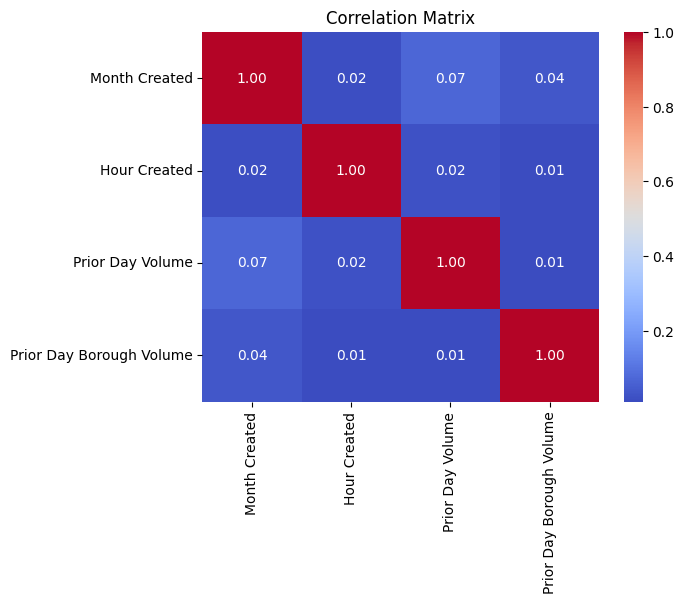

In [ ]:
correlation_matrix = X_train[ordinal_cols].corr(method='kendall')
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# source: https://www.statology.org/cramers-v-in-python/
for col1 in X_train.columns:
    for col2 in X_train.columns:
        if col1 == col2:
            continue
        table = pd.crosstab(
            X_train[col1],
            X_train[col2]
        )

        if table.shape[0] < 2 or table.shape[1] < 2:
            continue

        chi2, p_value, dof, expected = chi2_contingency(table)

        n = table.values.sum()
        min_dim = min(table.shape) - 1

        V = np.sqrt((chi2 / n) / min_dim)

        if V >= 0.7:
            print(f"{col1} vs {col2}")
            print(f"  Cramér's V: {V:.3f}")
            print(f"  p-value: {p_value:.3e}\n")

Mean Squared Error: 0.32956470663923715
R-squared: 0.06737521788608847


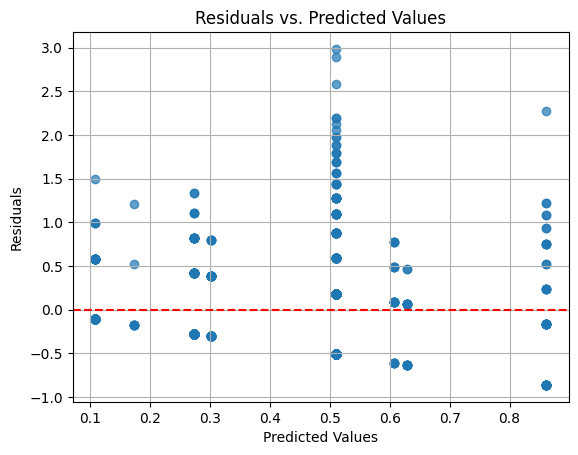

In [ ]:
dtr_model = DecisionTreeRegressor(max_depth=3)
dtr_model.fit(X_train, y_train)
y_pred = dtr_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")
plt.grid(True)
plt.show()

Best Parameters: {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best Estimator: DecisionTreeRegressor(max_depth=3, min_samples_split=10)
Mean Squared Error with best model: 0.3295647066392372
R-squared: 0.06737521788608813


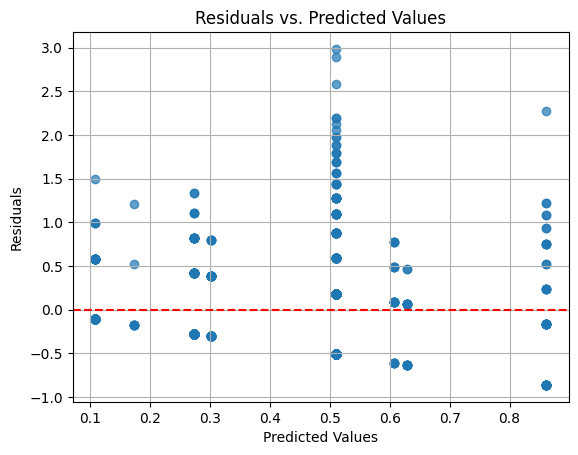

In [ ]:
param_grid = {
    'max_depth': [3, 50, 150, 250],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4],
    'max_features': [None, 'sqrt', 'log2']
}

grid_search = GridSearchCV(dtr_model, param_grid=param_grid, scoring='r2', cv=5)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)
print("Best Estimator:", grid_search.best_estimator_)
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error with best model: {mse}")
print(f"R-squared: {r2}")
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")
plt.grid(True)
plt.show()

Mean Squared Error: 0.3182423847261936
R-squared: 0.09941590001754885


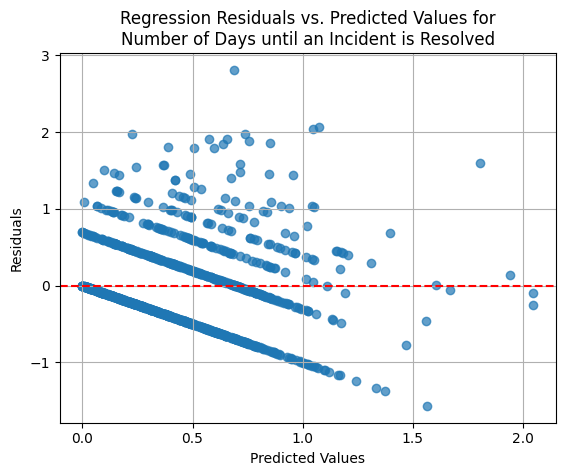

In [ ]:
rf = RandomForestRegressor(random_state=2)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Regression Residuals vs. Predicted Values for\nNumber of Days until an Incident is Resolved")
plt.grid(True)
plt.show()

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best Parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 47, 'bootstrap': False}
Best R2 Score: 0.1398094970541465
Mean Squared Error with best model: 0.2911967428852722
R-squared: 0.17595150993233077


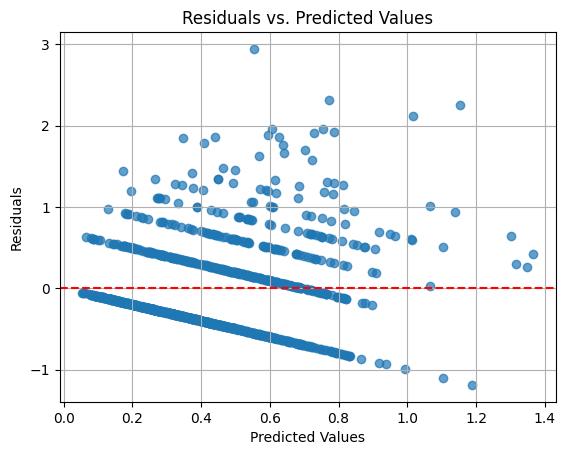

In [ ]:
# help from gemini for randomized search and permutation search
param_dist = {
    'n_estimators': [100, 300, 500],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [43, 44, 45, 47, 48, 49],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3],
    'bootstrap': [True, False]
}

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=25,
    cv=3,
    verbose=2,
    random_state=2,
    n_jobs=-1,
    scoring='r2'
)

rf_random.fit(X_train, y_train)

print(f"Best Parameters: {rf_random.best_params_}")
print(f"Best R2 Score: {rf_random.best_score_}")

best_model = rf_random.best_estimator_

y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error with best model: {mse}")
print(f"R-squared: {r2}")
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")
plt.grid(True)
plt.show()

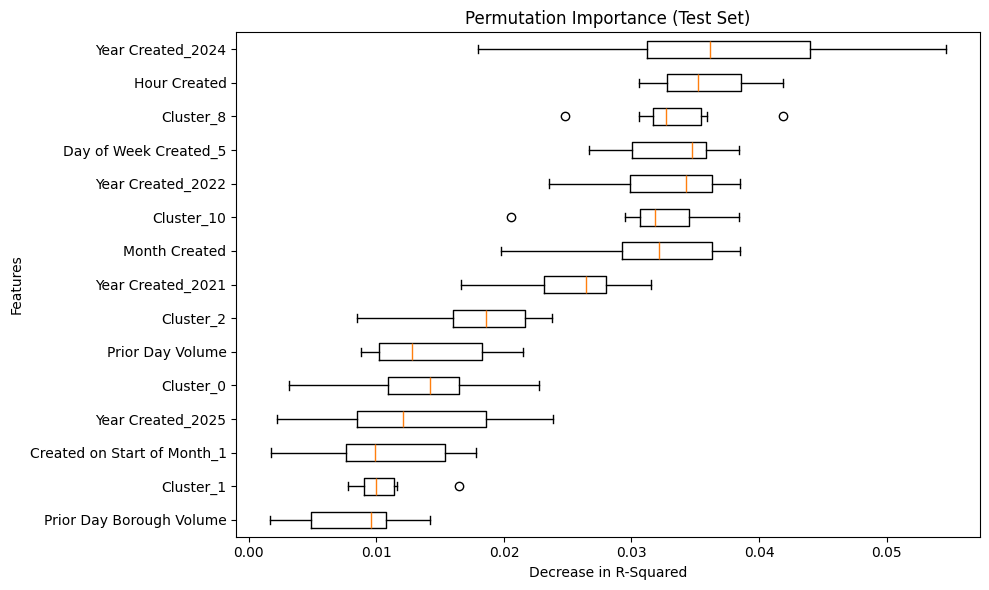

In [ ]:
result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=2, n_jobs=-1)

perm_sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(10, 6))
plt.boxplot(result.importances[perm_sorted_idx][-15:].T, vert=False, tick_labels=X_test.columns[perm_sorted_idx][-15:])
plt.title("Permutation Importance (Test Set)")
plt.ylabel("Features")
plt.xlabel("Decrease in R-Squared")
plt.tight_layout()
plt.show()

In [ ]:
results_df = scaled_df.loc[y_test.index].copy()
results_df['Predicted'] = y_pred
results_df['Residuals'] = residuals
results_df['AbsResidual'] = results_df['Residuals'].abs()
results_df_sorted = results_df.sort_values(by='AbsResidual', ascending=False)

results_df_sorted.head(10)

,Days Between Incident and Resolution,Hour Created,Month Created,Prior Day Volume,Prior Day Borough Volume,Location Type_Sidewalk,Location Type_Traffic Island or Median,Address Type_BLOCKFACE,Address Type_INTERSECTION,Day of Week Created_1,...,Cluster_9,Year Created_2020,Year Created_2021,Year Created_2022,Year Created_2023,Year Created_2024,Year Created_2025,Predicted,Residuals,AbsResidual
2634,32,-1.010298,-0.254466,-0.603474,0.151781,1,0,0,0,1,...,0,0,0,1,0,0,0,0.552629,2.943878,2.943878
3100,21,-1.010298,0.739894,-0.101816,0.907940,1,0,0,1,0,...,0,0,1,0,0,0,0,0.772333,2.318709,2.318709
3598,29,1.319412,0.408441,1.904816,-0.604379,0,0,1,0,0,...,0,1,0,0,0,0,0,1.152436,2.248761,2.248761
2607,22,-1.222090,0.076987,-0.101816,0.151781,1,0,0,0,0,...,0,0,0,1,0,0,0,1.015391,2.120103,2.120103
3052,12,-0.798506,1.071347,-0.101816,0.151781,1,0,0,0,0,...,0,0,1,0,0,0,0,0.607023,1.957927,1.957927
3175,14,1.531204,0.408441,-0.101816,-0.604379,0,0,0,0,0,...,0,0,1,0,0,0,0,0.753834,1.954216,1.954216
2444,14,-1.010298,0.739894,0.399842,0.151781,1,0,0,1,0,...,0,0,0,1,0,0,0,0.785900,1.922150,1.922150
2978,13,-0.374922,1.402801,-0.603474,-0.604379,1,0,0,0,0,...,0,0,1,0,0,0,0,0.727989,1.911068,1.911068
3493,11,-0.586714,1.071347,-0.101816,-0.604379,0,0,0,1,0,...,0,1,0,0,0,0,0,0.595677,1.889230,1.889230
2896,9,1.319412,-1.911732,-0.101816,-0.604379,1,0,0,1,0,...,0,0,0,1,0,0,0,0.440053,1.862532,1.862532


Mean Squared Error: 0.30238107434779815
R-squared: 0.14430132263012596


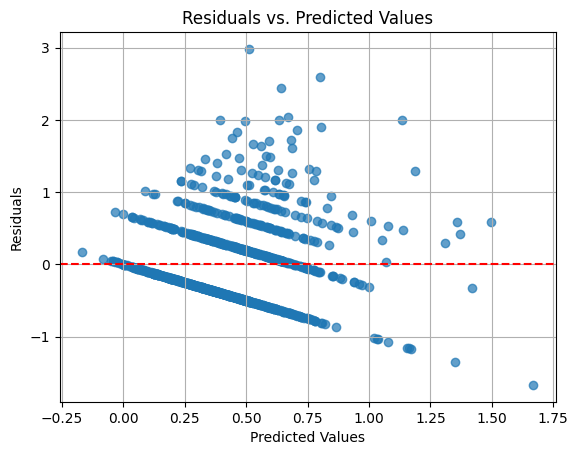

In [ ]:
gbr_model = GradientBoostingRegressor(random_state=2, loss='squared_error')
gbr_model.fit(X_train, y_train)
y_pred = gbr_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")
plt.grid(True)
plt.show()

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best R2 Score: 0.13634265169378826
Best Parameters: {'subsample': 0.7, 'n_estimators': 500, 'min_samples_split': 20, 'max_depth': 5, 'loss': 'squared_error', 'learning_rate': 0.01}
Mean Squared Error with best model: 0.29447406679280785
R-squared: 0.16667711424126552


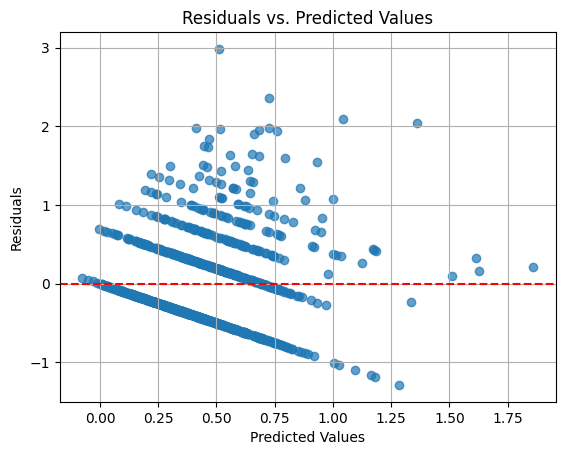

In [ ]:
param_dist = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [10, 20, 50],
    'subsample': [0.7, 0.8, 1.0],
    'loss': ['squared_error', 'huber']
}

random_search = RandomizedSearchCV(
    estimator=gbr_model,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print(f"Best R2 Score: {random_search.best_score_}")
print(f"Best Parameters: {random_search.best_params_}")

best_model = random_search.best_estimator_

y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error with best model: {mse}")
print(f"R-squared: {r2}")
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")
plt.grid(True)
plt.show()

## Classification to Predict How Service Request is Resolved

In [ ]:
syringe_service_requests_incident_resolution_df = syringe_service_requests_df.copy()

resolution_mapping = {
    'The Department of Sanitation cleaned the location.': 'Action Taken',
    'The Department of Sanitation removed the items.': 'Action Taken',
    'The Department of Sanitation collected the requested items.': 'Action Taken',
    'The vehicle you reported has been removed by the Department of Sanitation.': 'Action Taken',
    'The Department of Sanitation has investigated the complaint and addressed the issue. If the problem persists, call 311 to enter a new complaint. If you are outside of New York City, please call (212) NEW-YORK (212-639-9675).': 'Action Taken',
    'The Department of Sanitation investigated this complaint and found no condition at the location.': 'No Condition Found',
    'The Department of Sanitation investigated this complaint and found no violation at the location.': 'No Condition Found',
    'The Department of Sanitation investigated this complaint and no DSNY related conditions/violations were observed. Location will be referred to the appropriate agency for further action.': 'Referral or Outreach',
    'The Department of Sanitation has sent this complaint to the appropriate district garage or bureau for further action.': 'Referral or Outreach',
    'The Department of Sanitation will address the situation at the location by providing educational outreach about proper sanitation procedures.': 'Referral or Outreach',
    'The Department of Sanitation investigated this complaint and issued a Notice of Violation.': 'Warning or Pending',
    'If the abandoned vehicle meets the criteria to be classified as a derelict (i.e. junk) the Department of Sanitation (DSNY) will investigate and tag the vehicle within three business days.': 'Warning or Pending'
}

syringe_service_requests_incident_resolution_df['Resolution Description'] = syringe_service_requests_incident_resolution_df['Resolution Description'].replace(resolution_mapping)


data_leakage_and_overlapping_cols = ['Latitude', 'Longitude', 'Days Between Incident and Resolution']
similar_cols = ['Created Early', 'Incident Zip', 'Community Board', 'Borough']
syringe_service_requests_incident_resolution_df = syringe_service_requests_incident_resolution_df.drop(columns = data_leakage_and_overlapping_cols, axis = 1)
syringe_service_requests_incident_resolution_df = syringe_service_requests_incident_resolution_df.drop(columns = similar_cols, axis = 1)
categorical_cols = ['Location Type', 'Address Type', 'Day of Week Created', 'Created on Start of Month', 'Cluster', 'Year Created']
syringe_service_requests_incident_resolution_df = pd.get_dummies(syringe_service_requests_incident_resolution_df, columns=categorical_cols, drop_first=True, dtype=int)
syringe_service_requests_incident_resolution_df.drop('Location Type_Street', axis = 1, inplace = True)
ordinal_cols = ['Month Created', 'Hour Created', 'Prior Day Volume', 'Prior Day Borough Volume']
scaled_df = syringe_service_requests_incident_resolution_df.copy()
scaled_df[ordinal_cols] = StandardScaler().fit_transform(scaled_df[ordinal_cols])
X = scaled_df.drop('Resolution Description', axis = 1)
y = scaled_df['Resolution Description']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=2)

In [ ]:
dtc_model = DecisionTreeClassifier(class_weight = 'balanced', random_state=2)
dtc_model.fit(X_train, y_train)
y_pred = dtc_model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
                      precision    recall  f1-score   support

        Action Taken       0.29      0.32      0.31       231
  No Condition Found       0.78      0.75      0.76       808
Referral or Outreach       0.05      0.07      0.06        28
  Warning or Pending       0.00      0.00      0.00         8

            accuracy                           0.63      1075
           macro avg       0.28      0.28      0.28      1075
        weighted avg       0.65      0.63      0.64      1075



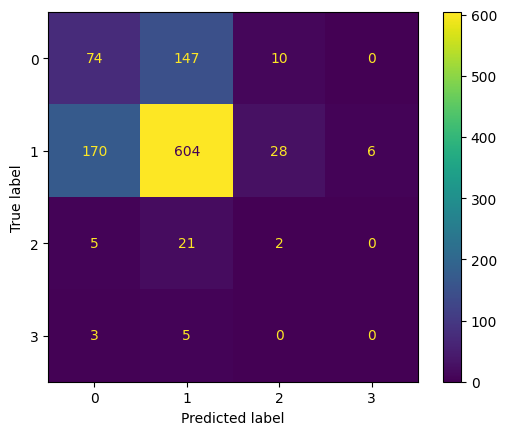

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': [10, 11, 12],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [2, 3, 4, 5],
    'max_features': [None, 'sqrt', 'log2'],
}

grid_search = GridSearchCV(dtc_model, param_grid, scoring='f1_macro', cv = 3)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

Best hyperparameters: {'criterion': 'entropy', 'max_depth': 12, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'random'}
Classification Report:
                       precision    recall  f1-score   support

        Action Taken       0.24      0.41      0.30       231
  No Condition Found       0.78      0.48      0.60       808
Referral or Outreach       0.05      0.25      0.09        28
  Warning or Pending       0.00      0.00      0.00         8

            accuracy                           0.46      1075
           macro avg       0.27      0.28      0.25      1075
        weighted avg       0.64      0.46      0.52      1075



In [ ]:
rfc_model = RandomForestClassifier(class_weight = 'balanced', random_state=2)
rfc_model.fit(X_train, y_train)
y_pred = rfc_model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
param_grid = {
    'n_estimators': [84, 85, 86],
    'criterion': ['entropy', 'gini', 'log_loss'],
    'max_depth': [None, 1],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', 'balanced_subsample']
}

grid_search = GridSearchCV(rfc_model, param_grid, scoring='f1_macro', cv = 3)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
param_grid = {
    'n_estimators': [75, 80, 85],
    'criterion': ['gini', 'log_loss'],
    'max_depth': [30, 35],
    'min_samples_leaf': [2, 3],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [
        'balanced',
        {'Action Taken': 1, 'No Condition Found': 0.5, 'Referral or Outreach': 4, 'Warning or Pending': 4}
    ]
}

grid_search = GridSearchCV(rfc_model, param_grid, scoring='f1_macro', cv = 3)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
class_names = ['Action Taken', 'No Condition Found', 'Referral or Outreach', 'Warning or Pending']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 5))
plt.xticks(rotation=45, ha='right')
plt.title("Confusion Matrix")
plt.show()

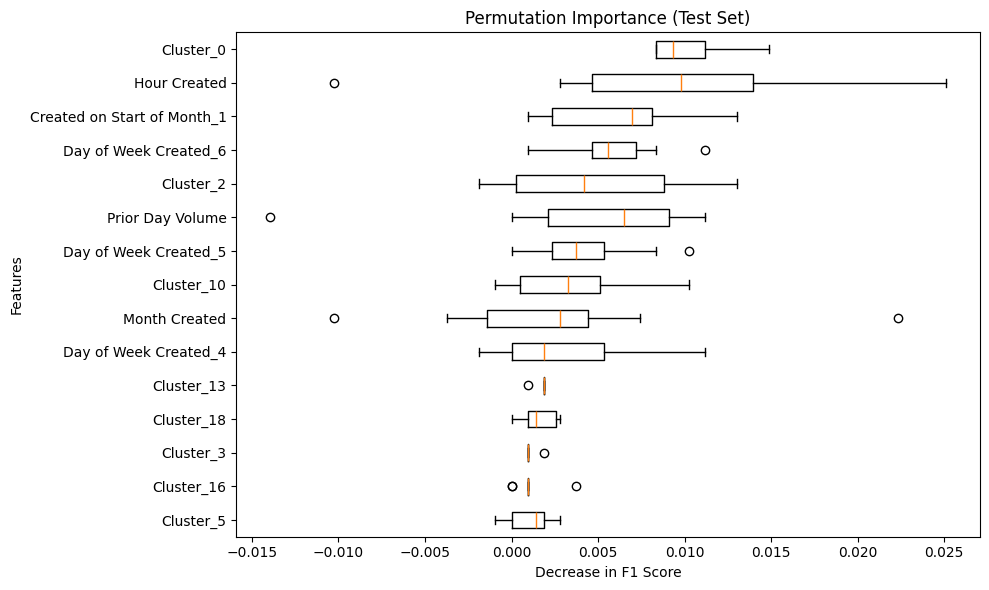

In [ ]:
result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=2, n_jobs=-1)
perm_sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(10, 6))
plt.boxplot(result.importances[perm_sorted_idx][-15:].T, vert=False, tick_labels=X_test.columns[perm_sorted_idx][-15:])
plt.title("Permutation Importance (Test Set)")
plt.xlabel("Decrease in F1 Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

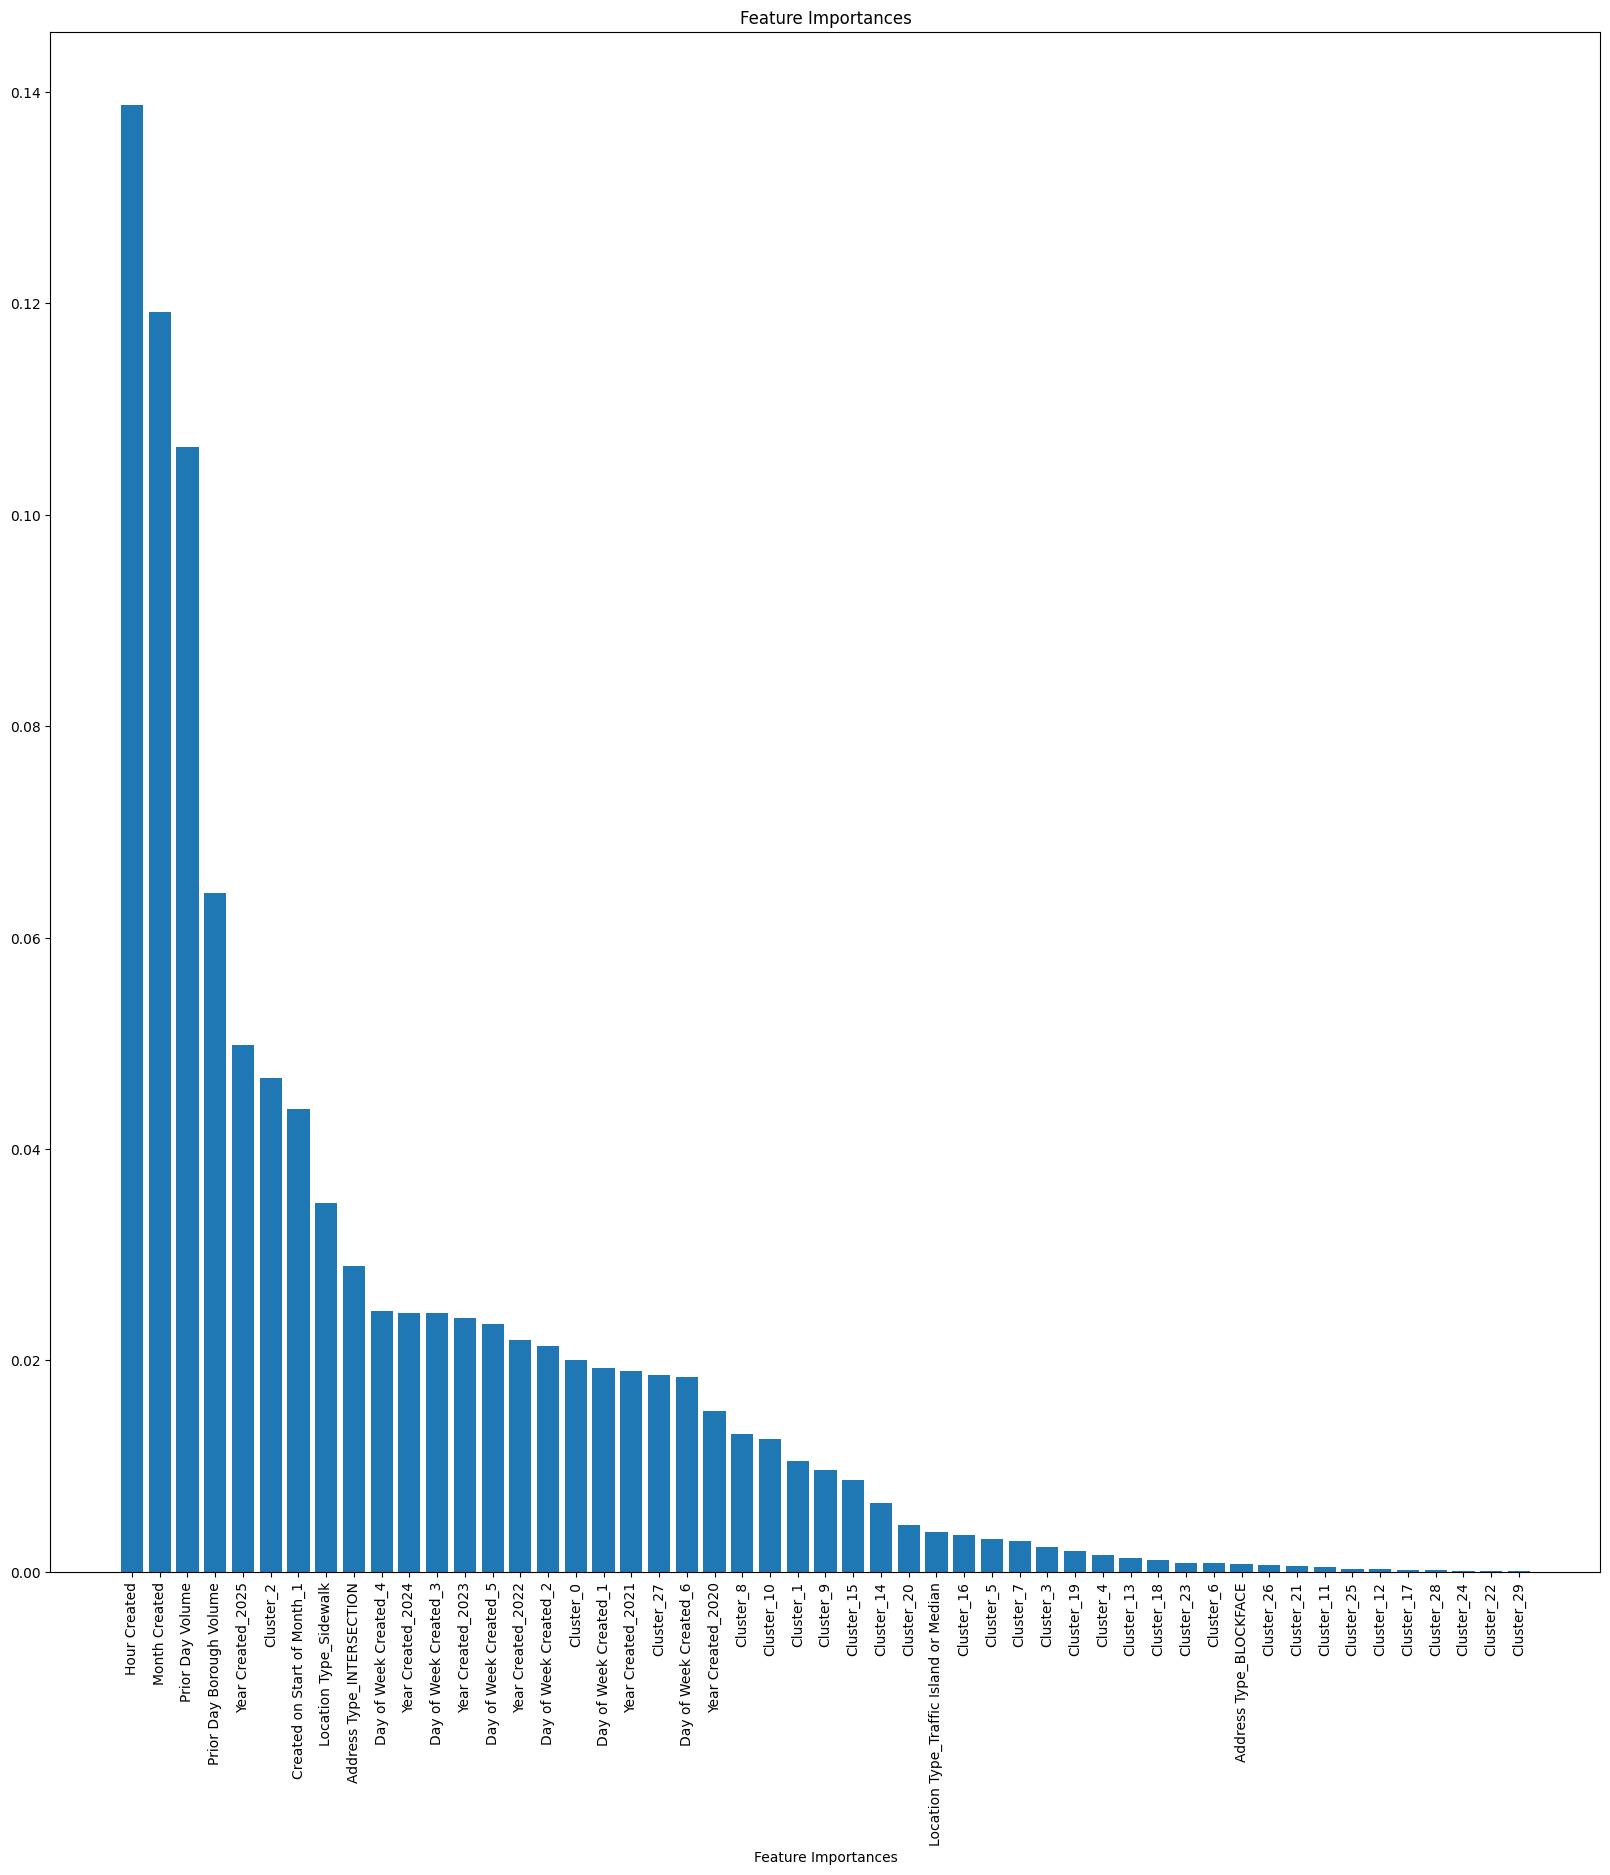

In [ ]:
importances = best_model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]
feature_names = X_train.columns
plt.figure(figsize=(20, 20))
plt.bar(range(X_train.shape[1]), importances[sorted_idx])
plt.xticks(range(X_train.shape[1]), np.array(feature_names)[sorted_idx], rotation=90)
plt.title("Feature Importances")
plt.xlabel("Feature Importances")
plt.show()

In [ ]:
gbc_model = GradientBoostingClassifier(random_state=2)
gbc_model.fit(X_train, y_train)
y_pred = gbc_model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
                      precision    recall  f1-score   support

        Action Taken       0.34      0.05      0.09       231
  No Condition Found       0.76      0.97      0.85       808
Referral or Outreach       0.00      0.00      0.00        28
  Warning or Pending       0.00      0.00      0.00         8

            accuracy                           0.74      1075
           macro avg       0.27      0.25      0.23      1075
        weighted avg       0.64      0.74      0.66      1075



Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best hyperparameters: {'subsample': 1.0, 'n_estimators': 500, 'min_samples_split': 10, 'max_depth': 4, 'learning_rate': 0.1}
Confusion Matrix:
 [[ 41 188   1   1]
 [ 67 732   5   4]
 [  2  25   1   0]
 [  1   6   0   1]]
Classification Report:
                       precision    recall  f1-score   support

        Action Taken       0.37      0.18      0.24       231
  No Condition Found       0.77      0.91      0.83       808
Referral or Outreach       0.14      0.04      0.06        28
  Warning or Pending       0.17      0.12      0.14         8

            accuracy                           0.72      1075
           macro avg       0.36      0.31      0.32      1075
        weighted avg       0.66      0.72      0.68      1075



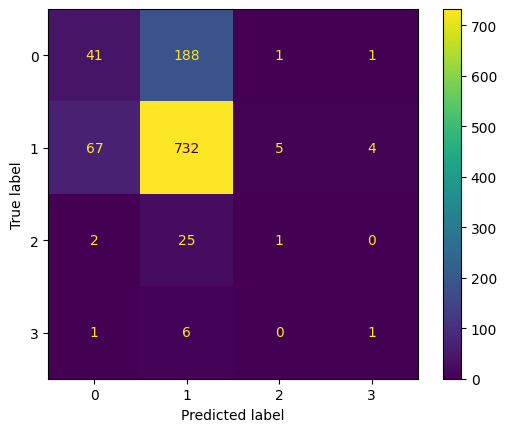

In [ ]:
param_dist = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [10, 20, 50],
    'subsample': [0.7, 0.8, 1.0],
}

random_search = RandomizedSearchCV(
    estimator=gbc_model,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring='f1_macro',
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_train, y_train)
best_params = random_search.best_params_
best_model = random_search.best_estimator_
print(f"Best hyperparameters: {best_params}")
accuracy = best_model.score(X_test, y_test)
y_pred = best_model.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()